# Cálculo de Overround y Simulación de Cuotas

## Descripción del Proyecto
Este notebook implementa el cálculo de **overround** (margen de ganancia) para convertir las predicciones de machine learning en cuotas de apuestas realistas y coherentes.

## Objetivos
1. **Convertir predicciones a probabilidades implícitas**
2. **Aplicar márgenes de ganancia (overround)**
3. **Validar coherencia de las cuotas generadas**
4. **Simular escenarios de apuestas**
5. **Comparar con cuotas reales del mercado**

## Conceptos Clave
- **Overround**: Margen de ganancia que asegura beneficio a la casa de apuestas
- **Probabilidades implícitas**: Probabilidades que se derivan de las cuotas
- **Coherencia**: Las probabilidades deben sumar > 100% para generar ganancia
- **Arbitraje**: Situaciones donde las cuotas permiten ganancia garantizada

In [91]:
# Librerías para manipulación de datos
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Librerías de machine learning (para cargar modelos)
import joblib
import pickle
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb

# Librerías para análisis financiero
from scipy import stats
from scipy.optimize import minimize

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Librerías importadas correctamente")
print("Listo para análisis de overround y simulación de cuotas")

Librerías importadas correctamente
Listo para análisis de overround y simulación de cuotas


## 1. Carga de Datos y Predicciones

Cargamos los datos de prueba y las predicciones de los mejores modelos del notebook anterior.

In [92]:
# Cargar datos de prueba
X_test = pd.read_csv('test_features.csv')
y_test = pd.read_csv('test_targets.csv')

# Eliminar columnas de índice si existen
if 'Unnamed: 0' in y_test.columns:
    y_test = y_test.drop('Unnamed: 0', axis=1)
if 'Unnamed: 0' in X_test.columns:
    X_test = X_test.drop('Unnamed: 0', axis=1)

# Seleccionar solo las cuotas de Bet365
target_columns = ['B365H', 'B365D', 'B365A']
y_test_b365 = y_test[target_columns].copy()

print("INFORMACIÓN DE LOS DATOS CARGADOS")
print("="*50)
print(f"Conjunto de prueba: {X_test.shape[0]} partidos")
print(f"Características: {X_test.shape[1]}")
print(f"Variables objetivo: {list(y_test_b365.columns)}")

print(f"\nEstadísticas de las cuotas reales:")
print(y_test_b365.describe().round(3))

# Verificar rango de cuotas
print(f"\nRango de cuotas:")
for col in target_columns:
    print(f"{col}: {y_test_b365[col].min():.3f} - {y_test_b365[col].max():.3f}")

INFORMACIÓN DE LOS DATOS CARGADOS
Conjunto de prueba: 1200 partidos
Características: 69
Variables objetivo: ['B365H', 'B365D', 'B365A']

Estadísticas de las cuotas reales:
          B365H     B365D     B365A
count  1200.000  1200.000  1200.000
mean      2.980     4.257     5.196
std       2.243     1.474     4.813
min       1.080     3.000     1.160
25%       1.670     3.400     2.400
50%       2.250     3.700     3.500
75%       3.200     4.500     5.750
max      23.000    13.000    34.000

Rango de cuotas:
B365H: 1.080 - 23.000
B365D: 3.000 - 13.000
B365A: 1.160 - 34.000


Recreamos los modelos utilizando los mejores hiperparámetros identificados en el análisis anterior. Usaremos XGBoost para las cuotas de victoria local y visitante, y Gradient Boosting para el empate, ya que estos fueron los algoritmos que mejor desempeño mostraron para cada variable objetivo específica.

In [93]:
# Cargar datos de entrenamiento para recrear los modelos
X_train = pd.read_csv('train_features.csv')
y_train = pd.read_csv('train_targets.csv')

# Limpiar datos de entrenamiento
if 'Unnamed: 0' in y_train.columns:
    y_train = y_train.drop('Unnamed: 0', axis=1)
if 'Unnamed: 0' in X_train.columns:
    X_train = X_train.drop('Unnamed: 0', axis=1)

y_train_b365 = y_train[target_columns].copy()

# Recrear los mejores modelos identificados en el notebook anterior
print("RECREANDO LOS MEJORES MODELOS...")
print("="*50)

# Basado en los resultados del notebook anterior:
# - XGBoost para B365H y B365A
# - Gradient Boosting para B365D

from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

# XGBoost para B365H
print("Entrenando XGBoost para B365H...")
xgb_h_model = XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    random_state=42
)
xgb_h_model.fit(X_train, y_train_b365['B365H'])

# Gradient Boosting para B365D  
print("Entrenando Gradient Boosting para B365D...")
gb_d_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)
gb_d_model.fit(X_train, y_train_b365['B365D'])

# XGBoost para B365A
print("Entrenando XGBoost para B365A...")
xgb_a_model = XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    random_state=42
)
xgb_a_model.fit(X_train, y_train_b365['B365A'])

print("Modelos entrenados exitosamente")

RECREANDO LOS MEJORES MODELOS...
Entrenando XGBoost para B365H...
Entrenando Gradient Boosting para B365D...
Entrenando Gradient Boosting para B365D...
Entrenando XGBoost para B365A...
Entrenando XGBoost para B365A...
Modelos entrenados exitosamente
Modelos entrenados exitosamente


Con los modelos entrenados, generamos predicciones sobre el conjunto de prueba y organizamos los datos en un DataFrame que nos permitirá comparar fácilmente las predicciones con los valores reales. Esta estructura será fundamental para los análisis posteriores de overround y simulación.

In [94]:
# Generar predicciones con los mejores modelos
print("GENERANDO PREDICCIONES...")
print("="*40)

# Hacer predicciones
pred_b365h = xgb_h_model.predict(X_test)
pred_b365d = gb_d_model.predict(X_test)  
pred_b365a = xgb_a_model.predict(X_test)

# Combinar predicciones en un DataFrame
predictions_df = pd.DataFrame({
    'B365H_pred': pred_b365h,
    'B365D_pred': pred_b365d,
    'B365A_pred': pred_b365a,
    'B365H_real': y_test_b365['B365H'].values,
    'B365D_real': y_test_b365['B365D'].values,
    'B365A_real': y_test_b365['B365A'].values
})

print(f"Predicciones generadas para {len(predictions_df)} partidos")
print(f"\nEstadísticas de las predicciones:")
print(predictions_df[['B365H_pred', 'B365D_pred', 'B365A_pred']].describe().round(3))

# Verificar que las predicciones están en un rango razonable
print(f"\nRango de predicciones:")
print(f"B365H: {pred_b365h.min():.3f} - {pred_b365h.max():.3f}")
print(f"B365D: {pred_b365d.min():.3f} - {pred_b365d.max():.3f}")  
print(f"B365A: {pred_b365a.min():.3f} - {pred_b365a.max():.3f}")

# Mostrar primeras predicciones
print(f"\nPrimeras 5 predicciones vs valores reales:")
print(predictions_df.head().round(3))

GENERANDO PREDICCIONES...
Predicciones generadas para 1200 partidos

Estadísticas de las predicciones:
       B365H_pred  B365D_pred  B365A_pred
count    1200.000    1200.000    1200.000
mean        2.812       4.103       4.923
std         1.596       0.964       3.648
min         1.130       3.219       1.249
25%         1.784       3.472       2.591
50%         2.312       3.710       3.528
75%         3.258       4.326       5.865
max        10.937       8.816      20.222

Rango de predicciones:
B365H: 1.130 - 10.937
B365D: 3.219 - 8.816
B365A: 1.249 - 20.222

Primeras 5 predicciones vs valores reales:
   B365H_pred  B365D_pred  B365A_pred  B365H_real  B365D_real  B365A_real
0       3.888       3.551       1.995        4.75         3.8        1.80
1       4.062       3.740       2.910        3.80         3.6        2.05
2       3.065       3.467       2.823        2.45         3.4        3.10
3       2.268       3.412       2.866        2.60         3.5        2.80
4       1.655   

Es importante validar que las predicciones estén dentro de rangos realistas para cuotas deportivas. Implementamos una función que corrige automáticamente valores extremos que podrían indicar predicciones poco confiables o errores en el modelo, asegurando que todas las cuotas estén entre 1.01 y 100.0.

In [95]:
# Validar y corregir predicciones fuera de rango
print("VALIDANDO RANGOS DE PREDICCIONES...")
print("="*45)

def validate_and_clip_odds(odds_array, min_odds=1.01, max_odds=100.0):
    """
    Valida y corrige cuotas que están fuera de rangos realistas.
    """
    original_count = len(odds_array)
    clipped_odds = np.clip(odds_array, min_odds, max_odds)
    
    out_of_range_low = np.sum(odds_array < min_odds)
    out_of_range_high = np.sum(odds_array > max_odds)
    
    return clipped_odds, out_of_range_low, out_of_range_high

# Validar cada conjunto de predicciones
for col, predictions in [('B365H', pred_b365h), ('B365D', pred_b365d), ('B365A', pred_b365a)]:
    clipped, low, high = validate_and_clip_odds(predictions)
    
    if low > 0 or high > 0:
        print(f"ADVERTENCIA {col} - Predicciones corregidas:")
        print(f"  - Demasiado bajas (< 1.01): {low}")
        print(f"  - Demasiado altas (> 100): {high}")
        
        # Actualizar predicciones
        if col == 'B365H':
            pred_b365h = clipped
            predictions_df['B365H_pred'] = clipped
        elif col == 'B365D':
            pred_b365d = clipped
            predictions_df['B365D_pred'] = clipped
        else:
            pred_b365a = clipped
            predictions_df['B365A_pred'] = clipped
    else:
        print(f"- {col} - Todas las predicciones en rango válido")

print(f"\nRangos finales después de validación:")
print(f"B365H: {pred_b365h.min():.3f} - {pred_b365h.max():.3f}")
print(f"B365D: {pred_b365d.min():.3f} - {pred_b365d.max():.3f}")
print(f"B365A: {pred_b365a.min():.3f} - {pred_b365a.max():.3f}")

VALIDANDO RANGOS DE PREDICCIONES...
- B365H - Todas las predicciones en rango válido
- B365D - Todas las predicciones en rango válido
- B365A - Todas las predicciones en rango válido

Rangos finales después de validación:
B365H: 1.130 - 10.937
B365D: 3.219 - 8.816
B365A: 1.249 - 20.222


## 2. Conversión a Probabilidades Implícitas

Convertimos las cuotas predichas y reales a probabilidades implícitas para análisis.

Implementamos las funciones fundamentales para trabajar con cuotas y probabilidades. Estas funciones nos permiten convertir entre cuotas decimales y probabilidades implícitas, así como calcular el overround que representa el margen de ganancia de la casa de apuestas. Probamos las funciones con ejemplos para verificar su correcto funcionamiento.

In [96]:
def odds_to_probability(odds):
    """
    Convierte cuotas decimales a probabilidades implícitas.
    
    Fórmula: probabilidad = 1 / cuota
    
    Args:
        odds: Cuota decimal (ej: 2.50)
    
    Returns:
        Probabilidad implícita (ej: 0.40 = 40%)
    """
    return 1 / odds

def probability_to_odds(probability):
    """
    Convierte probabilidades a cuotas decimales.
    
    Fórmula: cuota = 1 / probabilidad
    
    Args:
        probability: Probabilidad (ej: 0.40 = 40%)
    
    Returns:
        Cuota decimal (ej: 2.50)
    """
    return 1 / probability

def calculate_overround(odds_h, odds_d, odds_a):
    """
    Calcula el overround (margen de ganancia) de un conjunto de cuotas.
    
    Fórmula: overround = (1/cuota_h + 1/cuota_d + 1/cuota_a) - 1
    
    Args:
        odds_h, odds_d, odds_a: Cuotas para local, empate, visitante
    
    Returns:
        Overround como decimal (ej: 0.05 = 5% margen)
    """
    prob_h = odds_to_probability(odds_h)
    prob_d = odds_to_probability(odds_d)
    prob_a = odds_to_probability(odds_a)
    
    total_probability = prob_h + prob_d + prob_a
    overround = total_probability - 1
    
    return overround

# Probar las funciones con ejemplos
print("FUNCIONES DE CONVERSIÓN")
print("="*30)

# Ejemplo: cuota 2.50 = 40% de probabilidad
ejemplo_cuota = 2.50
ejemplo_prob = odds_to_probability(ejemplo_cuota)
print(f"Cuota {ejemplo_cuota} = {ejemplo_prob:.3f} probabilidad ({ejemplo_prob*100:.1f}%)")

# Ejemplo: 40% probabilidad = cuota 2.50
ejemplo_prob_2 = 0.40
ejemplo_cuota_2 = probability_to_odds(ejemplo_prob_2)
print(f"Probabilidad {ejemplo_prob_2:.2f} ({ejemplo_prob_2*100:.0f}%) = cuota {ejemplo_cuota_2:.2f}")

# Ejemplo de overround
ejemplo_h, ejemplo_d, ejemplo_a = 2.10, 3.40, 3.50
ejemplo_overround = calculate_overround(ejemplo_h, ejemplo_d, ejemplo_a)
print(f"\nEjemplo overround:")
print(f"Cuotas: H={ejemplo_h}, D={ejemplo_d}, A={ejemplo_a}")
print(f"Overround: {ejemplo_overround:.4f} ({ejemplo_overround*100:.2f}%)")

FUNCIONES DE CONVERSIÓN
Cuota 2.5 = 0.400 probabilidad (40.0%)
Probabilidad 0.40 (40%) = cuota 2.50

Ejemplo overround:
Cuotas: H=2.1, D=3.4, A=3.5
Overround: 0.0560 (5.60%)


Aplicamos las funciones de conversión a todo nuestro conjunto de datos para transformar tanto las predicciones como los valores reales a probabilidades implícitas. Este paso es esencial para poder analizar el comportamiento probabilístico del modelo y calcular métricas como el overround para cada partido.

In [97]:
# Convertir todas las cuotas a probabilidades implícitas
print("CONVERSIÓN A PROBABILIDADES IMPLÍCITAS")
print("="*50)

# Probabilidades de las predicciones
predictions_df['prob_H_pred'] = odds_to_probability(predictions_df['B365H_pred'])
predictions_df['prob_D_pred'] = odds_to_probability(predictions_df['B365D_pred'])
predictions_df['prob_A_pred'] = odds_to_probability(predictions_df['B365A_pred'])

# Probabilidades de los valores reales
predictions_df['prob_H_real'] = odds_to_probability(predictions_df['B365H_real'])
predictions_df['prob_D_real'] = odds_to_probability(predictions_df['B365D_real'])
predictions_df['prob_A_real'] = odds_to_probability(predictions_df['B365A_real'])

# Calcular overround para predicciones y valores reales
predictions_df['overround_pred'] = predictions_df.apply(
    lambda row: calculate_overround(row['B365H_pred'], row['B365D_pred'], row['B365A_pred']), 
    axis=1
)

predictions_df['overround_real'] = predictions_df.apply(
    lambda row: calculate_overround(row['B365H_real'], row['B365D_real'], row['B365A_real']), 
    axis=1
)

print("Estadísticas de probabilidades implícitas (predicciones):")
prob_cols_pred = ['prob_H_pred', 'prob_D_pred', 'prob_A_pred']
print(predictions_df[prob_cols_pred].describe().round(4))

print("\nEstadísticas de probabilidades implícitas (reales):")
prob_cols_real = ['prob_H_real', 'prob_D_real', 'prob_A_real'] 
print(predictions_df[prob_cols_real].describe().round(4))

print(f"\nEstadísticas de overround:")
print(f"Overround predicciones: {predictions_df['overround_pred'].describe().round(4)}")
print(f"Overround real: {predictions_df['overround_real'].describe().round(4)}")

# Verificar que las probabilidades suman más de 1 (indicando overround positivo)
sum_prob_pred = predictions_df[prob_cols_pred].sum(axis=1)
sum_prob_real = predictions_df[prob_cols_real].sum(axis=1)

print(f"\nSuma de probabilidades:")
print(f"Predicciones - Media: {sum_prob_pred.mean():.4f}, Min: {sum_prob_pred.min():.4f}, Max: {sum_prob_pred.max():.4f}")
print(f"Reales - Media: {sum_prob_real.mean():.4f}, Min: {sum_prob_real.min():.4f}, Max: {sum_prob_real.max():.4f}")

CONVERSIÓN A PROBABILIDADES IMPLÍCITAS
Estadísticas de probabilidades implícitas (predicciones):
       prob_H_pred  prob_D_pred  prob_A_pred
count    1200.0000    1200.0000    1200.0000
mean        0.4467       0.2538       0.3001
std         0.1872       0.0441       0.1656
min         0.0914       0.1134       0.0495
25%         0.3069       0.2312       0.1705
50%         0.4325       0.2695       0.2834
75%         0.5607       0.2880       0.3860
max         0.8848       0.3106       0.8009

Estadísticas de probabilidades implícitas (reales):
       prob_H_real  prob_D_real  prob_A_real
count    1200.0000    1200.0000    1200.0000
mean        0.4593       0.2531       0.3171
std         0.2100       0.0561       0.1883
min         0.0435       0.0769       0.0294
25%         0.3125       0.2222       0.1739
50%         0.4444       0.2703       0.2857
75%         0.5988       0.2941       0.4167
max         0.9259       0.3333       0.8621

Estadísticas de overround:
Overround pr

## 3. Aplicación de Márgenes de Ganancia (Overround)

Aplicamos diferentes estrategias para ajustar las probabilidades e incluir márgenes de ganancia realistas.

Implementamos diferentes estrategias para aplicar márgenes de ganancia a las probabilidades predichas. Cada método tiene características distintas: el proporcional mantiene las relaciones relativas, el uniforme distribuye el margen equitativamente, y el inverso-proporcional aplica mayor protección a eventos menos probables. Comparamos los resultados de cada método con ejemplos prácticos.

In [98]:
def apply_proportional_margin(prob_h, prob_d, prob_a, target_margin=0.05):
    """
    Aplica un margen de ganancia proporcional a las probabilidades.
    
    El margen se distribuye proporcionalmente entre todos los resultados.
    
    Args:
        prob_h, prob_d, prob_a: Probabilidades originales
        target_margin: Margen objetivo (ej: 0.05 = 5%)
    
    Returns:
        Tupla con (prob_h_adj, prob_d_adj, prob_a_adj, cuotas_adj)
    """
    # Normalizar probabilidades para que sumen 1
    total_prob = prob_h + prob_d + prob_a
    prob_h_norm = prob_h / total_prob
    prob_d_norm = prob_d / total_prob  
    prob_a_norm = prob_a / total_prob
    
    # Aplicar margen proporcionalmente
    margin_factor = 1 + target_margin
    prob_h_adj = prob_h_norm * margin_factor
    prob_d_adj = prob_d_norm * margin_factor
    prob_a_adj = prob_a_norm * margin_factor
    
    # Convertir a cuotas
    odds_h_adj = probability_to_odds(prob_h_adj)
    odds_d_adj = probability_to_odds(prob_d_adj)
    odds_a_adj = probability_to_odds(prob_a_adj)
    
    return prob_h_adj, prob_d_adj, prob_a_adj, odds_h_adj, odds_d_adj, odds_a_adj

def apply_uniform_margin(prob_h, prob_d, prob_a, target_margin=0.05):
    """
    Aplica un margen uniforme a todas las probabilidades.
    
    Cada probabilidad se incrementa por la misma cantidad.
    
    Args:
        prob_h, prob_d, prob_a: Probabilidades originales
        target_margin: Margen objetivo total
    
    Returns:
        Tupla con probabilidades y cuotas ajustadas
    """
    # Normalizar probabilidades
    total_prob = prob_h + prob_d + prob_a
    prob_h_norm = prob_h / total_prob
    prob_d_norm = prob_d / total_prob
    prob_a_norm = prob_a / total_prob
    
    # Aplicar margen uniforme
    margin_per_outcome = target_margin / 3
    prob_h_adj = prob_h_norm + margin_per_outcome
    prob_d_adj = prob_d_norm + margin_per_outcome
    prob_a_adj = prob_a_norm + margin_per_outcome
    
    # Convertir a cuotas
    odds_h_adj = probability_to_odds(prob_h_adj)
    odds_d_adj = probability_to_odds(prob_d_adj)
    odds_a_adj = probability_to_odds(prob_a_adj)
    
    return prob_h_adj, prob_d_adj, prob_a_adj, odds_h_adj, odds_d_adj, odds_a_adj

def apply_inverse_proportional_margin(prob_h, prob_d, prob_a, target_margin=0.05):
    """
    Aplica mayor margen a probabilidades menores (resultados menos probables).
    
    Esta estrategia protege más a la casa de apuestas en eventos improbables.
    
    Args:
        prob_h, prob_d, prob_a: Probabilidades originales
        target_margin: Margen objetivo total
    
    Returns:
        Tupla con probabilidades y cuotas ajustadas
    """
    # Normalizar probabilidades
    total_prob = prob_h + prob_d + prob_a
    prob_h_norm = prob_h / total_prob
    prob_d_norm = prob_d / total_prob
    prob_a_norm = prob_a / total_prob
    
    # Calcular factores de ajuste inversamente proporcionales
    probs = np.array([prob_h_norm, prob_d_norm, prob_a_norm])
    inverse_weights = 1 / probs
    inverse_weights = inverse_weights / inverse_weights.sum()
    
    # Distribuir el margen según los pesos inversos
    margin_distribution = target_margin * inverse_weights
    
    prob_h_adj = prob_h_norm + margin_distribution[0]
    prob_d_adj = prob_d_norm + margin_distribution[1]
    prob_a_adj = prob_a_norm + margin_distribution[2]
    
    # Convertir a cuotas
    odds_h_adj = probability_to_odds(prob_h_adj)
    odds_d_adj = probability_to_odds(prob_d_adj)
    odds_a_adj = probability_to_odds(prob_a_adj)
    
    return prob_h_adj, prob_d_adj, prob_a_adj, odds_h_adj, odds_d_adj, odds_a_adj

# Probar las funciones con un ejemplo
print("MÉTODOS DE APLICACIÓN DE MÁRGENES")
print("="*40)

# Ejemplo: probabilidades "justas" que suman 1
ejemplo_prob_h = 0.45  # 45% local
ejemplo_prob_d = 0.25  # 25% empate
ejemplo_prob_a = 0.30  # 30% visitante

print(f"Probabilidades originales:")
print(f"Local: {ejemplo_prob_h:.3f} ({ejemplo_prob_h*100:.1f}%)")
print(f"Empate: {ejemplo_prob_d:.3f} ({ejemplo_prob_d*100:.1f}%)")
print(f"Visitante: {ejemplo_prob_a:.3f} ({ejemplo_prob_a*100:.1f}%)")
print(f"Total: {ejemplo_prob_h + ejemplo_prob_d + ejemplo_prob_a:.3f}")

target_margin = 0.05  # 5% margen

print(f"\n1. MARGEN PROPORCIONAL ({target_margin*100:.0f}%):")
result_prop = apply_proportional_margin(ejemplo_prob_h, ejemplo_prob_d, ejemplo_prob_a, target_margin)
prob_h_prop, prob_d_prop, prob_a_prop, odds_h_prop, odds_d_prop, odds_a_prop = result_prop
print(f"Cuotas: H={odds_h_prop:.2f}, D={odds_d_prop:.2f}, A={odds_a_prop:.2f}")
print(f"Overround: {calculate_overround(odds_h_prop, odds_d_prop, odds_a_prop)*100:.2f}%")

print(f"\n2. MARGEN UNIFORME ({target_margin*100:.0f}%):")
result_unif = apply_uniform_margin(ejemplo_prob_h, ejemplo_prob_d, ejemplo_prob_a, target_margin)
prob_h_unif, prob_d_unif, prob_a_unif, odds_h_unif, odds_d_unif, odds_a_unif = result_unif
print(f"Cuotas: H={odds_h_unif:.2f}, D={odds_d_unif:.2f}, A={odds_a_unif:.2f}")
print(f"Overround: {calculate_overround(odds_h_unif, odds_d_unif, odds_a_unif)*100:.2f}%")

print(f"\n3. MARGEN INVERSO-PROPORCIONAL ({target_margin*100:.0f}%):")
result_inv = apply_inverse_proportional_margin(ejemplo_prob_h, ejemplo_prob_d, ejemplo_prob_a, target_margin)
prob_h_inv, prob_d_inv, prob_a_inv, odds_h_inv, odds_d_inv, odds_a_inv = result_inv
print(f"Cuotas: H={odds_h_inv:.2f}, D={odds_d_inv:.2f}, A={odds_a_inv:.2f}")
print(f"Overround: {calculate_overround(odds_h_inv, odds_d_inv, odds_a_inv)*100:.2f}%")

MÉTODOS DE APLICACIÓN DE MÁRGENES
Probabilidades originales:
Local: 0.450 (45.0%)
Empate: 0.250 (25.0%)
Visitante: 0.300 (30.0%)
Total: 1.000

1. MARGEN PROPORCIONAL (5%):
Cuotas: H=2.12, D=3.81, A=3.17
Overround: 5.00%

2. MARGEN UNIFORME (5%):
Cuotas: H=2.14, D=3.75, A=3.16
Overround: 5.00%

3. MARGEN INVERSO-PROPORCIONAL (5%):
Cuotas: H=2.17, D=3.69, A=3.15
Overround: 5.00%


Desarrollamos métodos más sofisticados que ajustan dinámicamente el margen según las características de cada partido. El método adaptativo utiliza la entropía para medir la incertidumbre y aplica márgenes mayores cuando las probabilidades están más equilibradas. El método Kelly-optimizado considera la varianza y el riesgo para determinar el margen óptimo desde una perspectiva de gestión de riesgo cuantitativa.

In [99]:
def apply_adaptive_margin(prob_h, prob_d, prob_a, base_margin=0.05, confidence_factor=1.0):
    """
    Aplica un margen adaptativo basado en la confianza de las predicciones.
    
    Cuanta mayor incertidumbre (probabilidades más equilibradas), mayor margen.
    
    Args:
        prob_h, prob_d, prob_a: Probabilidades originales
        base_margin: Margen base mínimo
        confidence_factor: Factor de ajuste por confianza
    
    Returns:
        Tupla con probabilidades y cuotas ajustadas
    """
    # Normalizar probabilidades
    total_prob = prob_h + prob_d + prob_a
    prob_h_norm = prob_h / total_prob
    prob_d_norm = prob_d / total_prob
    prob_a_norm = prob_a / total_prob
    
    # Calcular entropía como medida de incertidumbre
    probs = np.array([prob_h_norm, prob_d_norm, prob_a_norm])
    probs = np.clip(probs, 1e-10, 1)  # Evitar log(0)
    entropy = -np.sum(probs * np.log(probs))
    max_entropy = np.log(3)  # Máxima entropía para 3 resultados
    uncertainty = entropy / max_entropy
    
    # Ajustar margen basado en incertidumbre
    adaptive_margin = base_margin + (uncertainty * confidence_factor * 0.03)  # Max 3% adicional
    
    # Aplicar margen proporcionalmente
    margin_factor = 1 + adaptive_margin
    prob_h_adj = prob_h_norm * margin_factor
    prob_d_adj = prob_d_norm * margin_factor
    prob_a_adj = prob_a_norm * margin_factor
    
    # Convertir a cuotas
    odds_h_adj = probability_to_odds(prob_h_adj)
    odds_d_adj = probability_to_odds(prob_d_adj)
    odds_a_adj = probability_to_odds(prob_a_adj)
    
    return prob_h_adj, prob_d_adj, prob_a_adj, odds_h_adj, odds_d_adj, odds_a_adj, adaptive_margin

def apply_kelly_optimal_margin(prob_h, prob_d, prob_a, risk_tolerance=0.1):
    """
    Aplica márgenes optimizados usando principios del criterio de Kelly.
    
    Ajusta márgenes basado en el riesgo y la ventaja esperada.
    """
    # Normalizar probabilidades
    total_prob = prob_h + prob_d + prob_a
    prob_h_norm = prob_h / total_prob
    prob_d_norm = prob_d / total_prob
    prob_a_norm = prob_a / total_prob
    
    # Calcular varianza como medida de riesgo
    probs = np.array([prob_h_norm, prob_d_norm, prob_a_norm])
    variance = np.var(probs)
    
    # Margen base inversamente proporcional a la confianza
    base_margin = 0.02 + (variance * risk_tolerance)
    
    # Aplicar margen con ajuste por resultado menos probable (mayor protección)
    min_prob = np.min(probs)
    protection_factor = 1 + (1 - min_prob) * 0.02  # Hasta 2% adicional
    
    margin_factor = (1 + base_margin) * protection_factor
    prob_h_adj = prob_h_norm * margin_factor
    prob_d_adj = prob_d_norm * margin_factor
    prob_a_adj = prob_a_norm * margin_factor
    
    # Convertir a cuotas
    odds_h_adj = probability_to_odds(prob_h_adj)
    odds_d_adj = probability_to_odds(prob_d_adj)
    odds_a_adj = probability_to_odds(prob_a_adj)
    
    final_margin = (prob_h_adj + prob_d_adj + prob_a_adj) - 1
    
    return prob_h_adj, prob_d_adj, prob_a_adj, odds_h_adj, odds_d_adj, odds_a_adj, final_margin

# Probar los nuevos métodos
print(f"\n4. MARGEN ADAPTATIVO:")
result_adapt = apply_adaptive_margin(ejemplo_prob_h, ejemplo_prob_d, ejemplo_prob_a)
prob_h_adapt, prob_d_adapt, prob_a_adapt, odds_h_adapt, odds_d_adapt, odds_a_adapt, margin_adapt = result_adapt
print(f"Cuotas: H={odds_h_adapt:.2f}, D={odds_d_adapt:.2f}, A={odds_a_adapt:.2f}")
print(f"Margen adaptativo: {margin_adapt*100:.2f}%")
print(f"Overround: {calculate_overround(odds_h_adapt, odds_d_adapt, odds_a_adapt)*100:.2f}%")

print(f"\n5. MARGEN KELLY-OPTIMIZADO:")
result_kelly = apply_kelly_optimal_margin(ejemplo_prob_h, ejemplo_prob_d, ejemplo_prob_a)
prob_h_kelly, prob_d_kelly, prob_a_kelly, odds_h_kelly, odds_d_kelly, odds_a_kelly, margin_kelly = result_kelly
print(f"Cuotas: H={odds_h_kelly:.2f}, D={odds_d_kelly:.2f}, A={odds_a_kelly:.2f}")
print(f"Margen Kelly: {margin_kelly*100:.2f}%")
print(f"Overround: {calculate_overround(odds_h_kelly, odds_d_kelly, odds_a_kelly)*100:.2f}%")


4. MARGEN ADAPTATIVO:
Cuotas: H=2.06, D=3.71, A=3.09
Margen adaptativo: 7.91%
Overround: 7.91%

5. MARGEN KELLY-OPTIMIZADO:
Cuotas: H=2.14, D=3.86, A=3.22
Margen Kelly: 3.60%
Overround: 3.60%


Ahora aplicamos sistemáticamente los métodos de margen más prometedores (proporcional y uniforme) a todo el conjunto de predicciones. Utilizamos como referencia el overround promedio de las cuotas reales de Bet365 para asegurar que nuestros márgenes sean competitivos y realistas en el mercado. Este proceso masivo nos permitirá evaluar la efectividad de cada método a gran escala.

In [100]:
# Aplicar diferentes márgenes a todas las predicciones
print("APLICANDO MÁRGENES A TODAS LAS PREDICCIONES")
print("="*50)

# Analizar el overround promedio de las cuotas reales para usar como referencia
overround_real_promedio = predictions_df['overround_real'].mean()
print(f"Overround promedio de cuotas reales: {overround_real_promedio*100:.2f}%")

# Usaremos este valor como target para nuestros márgenes
target_margin = overround_real_promedio

# Aplicar margen proporcional a todas las predicciones
print(f"\nAplicando margen proporcional ({target_margin*100:.2f}%)...")

results_proportional = []
for idx, row in predictions_df.iterrows():
    result = apply_proportional_margin(
        row['prob_H_pred'], 
        row['prob_D_pred'], 
        row['prob_A_pred'], 
        target_margin
    )
    prob_h_adj, prob_d_adj, prob_a_adj, odds_h_adj, odds_d_adj, odds_a_adj = result
    
    results_proportional.append({
        'prob_H_adj': prob_h_adj,
        'prob_D_adj': prob_d_adj,
        'prob_A_adj': prob_a_adj,
        'odds_H_adj': odds_h_adj,
        'odds_D_adj': odds_d_adj,
        'odds_A_adj': odds_a_adj
    })

# Convertir a DataFrame y agregar a predictions_df
results_prop_df = pd.DataFrame(results_proportional)
for col in results_prop_df.columns:
    predictions_df[f'prop_{col}'] = results_prop_df[col]

# Calcular overround de las cuotas ajustadas
predictions_df['overround_prop_adj'] = predictions_df.apply(
    lambda row: calculate_overround(row['prop_odds_H_adj'], row['prop_odds_D_adj'], row['prop_odds_A_adj']), 
    axis=1
)

print(f"Overround promedio después de ajuste proporcional: {predictions_df['overround_prop_adj'].mean()*100:.2f}%")

# Aplicar margen uniforme
print(f"\nAplicando margen uniforme ({target_margin*100:.2f}%)...")

results_uniform = []
for idx, row in predictions_df.iterrows():
    result = apply_uniform_margin(
        row['prob_H_pred'], 
        row['prob_D_pred'], 
        row['prob_A_pred'], 
        target_margin
    )
    prob_h_adj, prob_d_adj, prob_a_adj, odds_h_adj, odds_d_adj, odds_a_adj = result
    
    results_uniform.append({
        'prob_H_adj': prob_h_adj,
        'prob_D_adj': prob_d_adj,
        'prob_A_adj': prob_a_adj,
        'odds_H_adj': odds_h_adj,
        'odds_D_adj': odds_d_adj,
        'odds_A_adj': odds_a_adj
    })

# Convertir a DataFrame y agregar a predictions_df
results_unif_df = pd.DataFrame(results_uniform)
for col in results_unif_df.columns:
    predictions_df[f'unif_{col}'] = results_unif_df[col]

# Calcular overround de las cuotas ajustadas uniformemente
predictions_df['overround_unif_adj'] = predictions_df.apply(
    lambda row: calculate_overround(row['unif_odds_H_adj'], row['unif_odds_D_adj'], row['unif_odds_A_adj']), 
    axis=1
)

print(f"Overround promedio después de ajuste uniforme: {predictions_df['overround_unif_adj'].mean()*100:.2f}%")

# Mostrar estadísticas de las cuotas ajustadas
print(f"\nEstadísticas de cuotas ajustadas (método proporcional):")
odds_cols_prop = ['prop_odds_H_adj', 'prop_odds_D_adj', 'prop_odds_A_adj']
print(predictions_df[odds_cols_prop].describe().round(3))

print(f"\nComparación primeras 5 predicciones:")
comparison_cols = ['B365H_pred', 'B365D_pred', 'B365A_pred', 
                  'prop_odds_H_adj', 'prop_odds_D_adj', 'prop_odds_A_adj',
                  'B365H_real', 'B365D_real', 'B365A_real']
print(predictions_df[comparison_cols].head().round(3))

APLICANDO MÁRGENES A TODAS LAS PREDICCIONES
Overround promedio de cuotas reales: 2.95%

Aplicando margen proporcional (2.95%)...
Overround promedio de cuotas reales: 2.95%

Aplicando margen proporcional (2.95%)...
Overround promedio después de ajuste proporcional: 2.95%

Aplicando margen uniforme (2.95%)...
Overround promedio después de ajuste uniforme: 2.95%

Estadísticas de cuotas ajustadas (método proporcional):
       prop_odds_H_adj  prop_odds_D_adj  prop_odds_A_adj
count         1200.000         1200.000         1200.000
mean             2.731            3.985            4.780
std              1.574            0.958            3.582
min              1.168            2.884            1.370
25%              1.700            3.396            2.482
50%              2.253            3.583            3.439
75%              3.032            4.151            5.542
max             10.341            8.528           20.939

Comparación primeras 5 predicciones:
   B365H_pred  B365D_pred  B36

## 4. Validación de Coherencia de Cuotas

Verificamos que las cuotas generadas sean coherentes y no permitan arbitraje.

Implementamos un sistema completo de validación que verifica la coherencia matemática y comercial de las cuotas generadas. Las funciones detectan oportunidades de arbitraje, validan rangos de overround aceptables, y calculan distribuciones óptimas de apuestas. Esta validación es fundamental para asegurar que el sistema sea robusto y no presente vulnerabilidades financieras.

In [101]:
def validate_odds_coherence(odds_h, odds_d, odds_a, min_overround=0.01, max_overround=0.15):
    """
    Valida que las cuotas sean coherentes para una casa de apuestas.
    
    Criterios de validación:
    1. Todas las cuotas deben ser >= 1.01 (probabilidad <= 99%)
    2. El overround debe estar entre min_overround y max_overround
    3. No debe existir oportunidad de arbitraje
    
    Args:
        odds_h, odds_d, odds_a: Cuotas para local, empate, visitante
        min_overround: Margen mínimo aceptable
        max_overround: Margen máximo aceptable
    
    Returns:
        Dict con resultado de validación y métricas
    """
    # Verificar que las cuotas son válidas
    min_odds = 1.01
    if odds_h < min_odds or odds_d < min_odds or odds_a < min_odds:
        return {
            'valid': False,
            'reason': 'Cuotas demasiado bajas (probabilidad > 99%)',
            'overround': None,
            'arbitrage_opportunity': None
        }
    
    # Calcular overround
    overround = calculate_overround(odds_h, odds_d, odds_a)
    
    # Verificar rango de overround
    if overround < min_overround:
        return {
            'valid': False,
            'reason': f'Overround demasiado bajo ({overround*100:.2f}% < {min_overround*100:.2f}%)',
            'overround': overround,
            'arbitrage_opportunity': overround < 0
        }
    
    if overround > max_overround:
        return {
            'valid': False,
            'reason': f'Overround demasiado alto ({overround*100:.2f}% > {max_overround*100:.2f}%)',
            'overround': overround,
            'arbitrage_opportunity': False
        }
    
    # Verificar oportunidad de arbitraje (suma de probabilidades < 1)
    arbitrage_opportunity = overround < 0
    
    return {
        'valid': True,
        'reason': 'Cuotas válidas y coherentes',
        'overround': overround,
        'arbitrage_opportunity': arbitrage_opportunity
    }

def detect_arbitrage_opportunities(odds_sets):
    """
    Detecta oportunidades de arbitraje en un conjunto de cuotas.
    
    Args:
        odds_sets: Lista de tuplas (odds_h, odds_d, odds_a)
    
    Returns:
        Lista de oportunidades de arbitraje con rentabilidad esperada
    """
    arbitrage_opportunities = []
    
    for i, (odds_h, odds_d, odds_a) in enumerate(odds_sets):
        overround = calculate_overround(odds_h, odds_d, odds_a)
        
        if overround < 0:  # Suma de probabilidades < 1 = arbitraje
            profit_margin = abs(overround)
            arbitrage_opportunities.append({
                'index': i,
                'odds': (odds_h, odds_d, odds_a),
                'overround': overround,
                'profit_margin': profit_margin,
                'profit_percentage': profit_margin * 100
            })
    
    return arbitrage_opportunities

def calculate_optimal_stake_distribution(odds_h, odds_d, odds_a, total_stake=100):
    """
    Calcula la distribución óptima de apuestas para arbitraje.
    
    Args:
        odds_h, odds_d, odds_a: Cuotas para cada resultado
        total_stake: Cantidad total a apostar
    
    Returns:
        Dict con distribución óptima de apuestas
    """
    # Probabilidades implícitas
    prob_h = odds_to_probability(odds_h)
    prob_d = odds_to_probability(odds_d)
    prob_a = odds_to_probability(odds_a)
    
    total_prob = prob_h + prob_d + prob_a
    
    if total_prob >= 1:
        return {
            'no_arbitrage': True,
            'reason': 'No hay oportunidad de arbitraje'
        }
    
    # Distribución proporcional a las probabilidades implícitas
    stake_h = (prob_h / total_prob) * total_stake
    stake_d = (prob_d / total_prob) * total_stake
    stake_a = (prob_a / total_prob) * total_stake
    
    # Calcular ganancias esperadas para cada resultado
    payout_h = stake_h * odds_h
    payout_d = stake_d * odds_d
    payout_a = stake_a * odds_a
    
    profit = min(payout_h, payout_d, payout_a) - total_stake
    
    return {
        'no_arbitrage': False,
        'stakes': {'local': stake_h, 'empate': stake_d, 'visitante': stake_a},
        'payouts': {'local': payout_h, 'empate': payout_d, 'visitante': payout_a},
        'guaranteed_profit': profit,
        'profit_percentage': (profit / total_stake) * 100
    }

# Probar las funciones de validación
print("FUNCIONES DE VALIDACIÓN DE COHERENCIA")
print("="*45)

# Ejemplo 1: Cuotas válidas
print("Ejemplo 1 - Cuotas válidas:")
odds_validas = (2.10, 3.40, 3.50)
validacion = validate_odds_coherence(*odds_validas)
print(f"Cuotas: {odds_validas}")
print(f"Resultado: {validacion}")

# Ejemplo 2: Cuotas con arbitraje
print(f"\nEjemplo 2 - Cuotas con arbitraje:")
odds_arbitraje = (2.50, 4.00, 2.80)
validacion_arb = validate_odds_coherence(*odds_arbitraje)
print(f"Cuotas: {odds_arbitraje}")
print(f"Resultado: {validacion_arb}")

if validacion_arb['arbitrage_opportunity']:
    distribucion = calculate_optimal_stake_distribution(*odds_arbitraje)
    print(f"Distribución óptima: {distribucion}")

# Ejemplo 3: Overround demasiado alto
print(f"\nEjemplo 3 - Overround alto:")
odds_alto = (1.50, 2.00, 2.50)
validacion_alto = validate_odds_coherence(*odds_alto)
print(f"Cuotas: {odds_alto}")
print(f"Resultado: {validacion_alto}")

FUNCIONES DE VALIDACIÓN DE COHERENCIA
Ejemplo 1 - Cuotas válidas:
Cuotas: (2.1, 3.4, 3.5)
Resultado: {'valid': True, 'reason': 'Cuotas válidas y coherentes', 'overround': 0.056022408963585235, 'arbitrage_opportunity': False}

Ejemplo 2 - Cuotas con arbitraje:
Cuotas: (2.5, 4.0, 2.8)
Resultado: {'valid': False, 'reason': 'Overround demasiado bajo (0.71% < 1.00%)', 'overround': 0.0071428571428571175, 'arbitrage_opportunity': False}

Ejemplo 3 - Overround alto:
Cuotas: (1.5, 2.0, 2.5)
Resultado: {'valid': False, 'reason': 'Overround demasiado alto (56.67% > 15.00%)', 'overround': 0.5666666666666664, 'arbitrage_opportunity': False}


Para evaluar la calidad de nuestras cuotas de manera más rigurosa, implementamos métricas avanzadas que van más allá de comparaciones simples. Calculamos el Log Loss para medir la precisión probabilística, el Sharpe Ratio para evaluar la consistencia de las predicciones, la distancia de Hellinger para medir similitud entre distribuciones, y el error de calibración para verificar que las probabilidades predichas correspondan con las frecuencias observadas.

In [102]:
def calculate_advanced_metrics(predictions_df):
    """
    Calcula métricas avanzadas para evaluar la calidad de las cuotas.
    """
    metrics = {}
    
    # 1. Log Loss (Brier Score adaptado para cuotas)
    def calculate_log_loss_odds(real_odds, pred_odds):
        real_probs = 1 / real_odds
        pred_probs = 1 / pred_odds
        
        # Normalizar probabilidades
        real_probs_norm = real_probs / real_probs.sum()
        pred_probs_norm = pred_probs / pred_probs.sum()
        
        # Evitar log(0)
        pred_probs_norm = np.clip(pred_probs_norm, 1e-15, 1-1e-15)
        
        return -np.sum(real_probs_norm * np.log(pred_probs_norm))
    
    # 2. Sharpe Ratio de las cuotas
    def calculate_odds_sharpe_ratio(real_odds, pred_odds):
        returns = (pred_odds - real_odds) / real_odds
        if np.std(returns) == 0:
            return 0
        return np.mean(returns) / np.std(returns)
    
    # 3. Distancia de Hellinger entre distribuciones
    def hellinger_distance(p, q):
        return np.sqrt(0.5 * np.sum((np.sqrt(p) - np.sqrt(q))**2))
    
    # Calcular métricas para cada partido
    log_losses = []
    sharpe_ratios = []
    hellinger_distances = []
    
    for _, row in predictions_df.iterrows():
        # Cuotas reales y predichas
        real_odds = np.array([row['B365H_real'], row['B365D_real'], row['B365A_real']])
        pred_odds = np.array([row['prop_odds_H_adj'], row['prop_odds_D_adj'], row['prop_odds_A_adj']])
        
        # Log Loss
        log_loss = calculate_log_loss_odds(real_odds, pred_odds)
        log_losses.append(log_loss)
        
        # Sharpe Ratio
        sharpe = calculate_odds_sharpe_ratio(real_odds, pred_odds)
        sharpe_ratios.append(sharpe)
        
        # Hellinger Distance
        real_probs = 1 / real_odds
        pred_probs = 1 / pred_odds
        real_probs_norm = real_probs / real_probs.sum()
        pred_probs_norm = pred_probs / pred_probs.sum()
        
        hellinger = hellinger_distance(real_probs_norm, pred_probs_norm)
        hellinger_distances.append(hellinger)
    
    metrics['log_loss_mean'] = np.mean(log_losses)
    metrics['log_loss_std'] = np.std(log_losses)
    metrics['sharpe_ratio_mean'] = np.mean(sharpe_ratios)
    metrics['sharpe_ratio_std'] = np.std(sharpe_ratios)
    metrics['hellinger_distance_mean'] = np.mean(hellinger_distances)
    metrics['hellinger_distance_std'] = np.std(hellinger_distances)
    
    # 4. Calibración de probabilidades
    def calculate_calibration_error(predictions_df):
        """Calcula el error de calibración de las probabilidades."""
        calibration_errors = []
        
        for outcome in ['H', 'D', 'A']:
            pred_probs = predictions_df[f'prop_prob_{outcome}_adj'].values
            real_probs = predictions_df[f'prob_{outcome}_real'].values
            
            # Agrupar en bins
            n_bins = 10
            bin_boundaries = np.linspace(0, 1, n_bins + 1)
            bin_lowers = bin_boundaries[:-1]
            bin_uppers = bin_boundaries[1:]
            
            ece = 0  # Expected Calibration Error
            for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
                in_bin = (pred_probs > bin_lower) & (pred_probs <= bin_upper)
                prop_in_bin = in_bin.mean()
                
                if prop_in_bin > 0:
                    accuracy_in_bin = real_probs[in_bin].mean()
                    avg_confidence_in_bin = pred_probs[in_bin].mean()
                    ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
            
            calibration_errors.append(ece)
        
        return np.mean(calibration_errors)
    
    metrics['calibration_error'] = calculate_calibration_error(predictions_df)
    
    return metrics

# Calcular métricas avanzadas
print("MÉTRICAS AVANZADAS DE EVALUACIÓN")
print("="*40)

advanced_metrics = calculate_advanced_metrics(predictions_df)

print("Calidad de las cuotas ajustadas:")
print(f"• Log Loss promedio: {advanced_metrics['log_loss_mean']:.4f} (±{advanced_metrics['log_loss_std']:.4f})")
print(f"• Sharpe Ratio promedio: {advanced_metrics['sharpe_ratio_mean']:.4f} (±{advanced_metrics['sharpe_ratio_std']:.4f})")
print(f"• Distancia Hellinger promedio: {advanced_metrics['hellinger_distance_mean']:.4f} (±{advanced_metrics['hellinger_distance_std']:.4f})")
print(f"• Error de calibración: {advanced_metrics['calibration_error']:.4f}")

print(f"\nInterpretación:")
print(f"• Log Loss < 1.0 = Bueno, < 0.5 = Excelente")
print(f"• Sharpe Ratio > 0 = Predicciones consistentemente mejores")
print(f"• Distancia Hellinger < 0.3 = Distribuciones similares")
print(f"• Error calibración < 0.1 = Bien calibrado")

MÉTRICAS AVANZADAS DE EVALUACIÓN
Calidad de las cuotas ajustadas:
• Log Loss promedio: 0.9717 (±0.1589)
• Sharpe Ratio promedio: -0.0846 (±0.4592)
• Distancia Hellinger promedio: 0.0489 (±0.0363)
• Error de calibración: 0.0087

Interpretación:
• Log Loss < 1.0 = Bueno, < 0.5 = Excelente
• Sharpe Ratio > 0 = Predicciones consistentemente mejores
• Distancia Hellinger < 0.3 = Distribuciones similares
• Error calibración < 0.1 = Bien calibrado
Calidad de las cuotas ajustadas:
• Log Loss promedio: 0.9717 (±0.1589)
• Sharpe Ratio promedio: -0.0846 (±0.4592)
• Distancia Hellinger promedio: 0.0489 (±0.0363)
• Error de calibración: 0.0087

Interpretación:
• Log Loss < 1.0 = Bueno, < 0.5 = Excelente
• Sharpe Ratio > 0 = Predicciones consistentemente mejores
• Distancia Hellinger < 0.3 = Distribuciones similares
• Error calibración < 0.1 = Bien calibrado


Aplicamos la validación de coherencia a todo el conjunto de datos para verificar sistemáticamente que las cuotas ajustadas sean comercialmente viables. Este análisis masivo nos permite comparar la efectividad de diferentes métodos de ajuste, identificar patrones problemáticos, y asegurar que nuestro sistema sea robusto frente a diferentes tipos de eventos deportivos. También comparamos con las cuotas reales de Bet365 como benchmark.

In [103]:
# Validar coherencia de todas las cuotas ajustadas
print("VALIDACIÓN DE COHERENCIA - DATASET COMPLETO")
print("="*50)

# Validar cuotas con margen proporcional
print("Validando cuotas con margen proporcional...")
validaciones_prop = []

for idx, row in predictions_df.iterrows():
    validacion = validate_odds_coherence(
        row['prop_odds_H_adj'], 
        row['prop_odds_D_adj'], 
        row['prop_odds_A_adj']
    )
    validaciones_prop.append(validacion)

# Agregar resultados de validación al DataFrame
predictions_df['prop_valid'] = [v['valid'] for v in validaciones_prop]
predictions_df['prop_arbitrage'] = [v['arbitrage_opportunity'] for v in validaciones_prop]

# Estadísticas de validación
cuotas_validas_prop = sum(predictions_df['prop_valid'])
total_cuotas = len(predictions_df)
arbitrajes_prop = sum(predictions_df['prop_arbitrage'])

print(f"Cuotas válidas (proporcional): {cuotas_validas_prop}/{total_cuotas} ({cuotas_validas_prop/total_cuotas*100:.1f}%)")
print(f"Oportunidades de arbitraje (proporcional): {arbitrajes_prop}")

# Validar cuotas con margen uniforme  
print(f"\nValidando cuotas con margen uniforme...")
validaciones_unif = []

for idx, row in predictions_df.iterrows():
    validacion = validate_odds_coherence(
        row['unif_odds_H_adj'], 
        row['unif_odds_D_adj'], 
        row['unif_odds_A_adj']
    )
    validaciones_unif.append(validacion)

# Agregar resultados al DataFrame
predictions_df['unif_valid'] = [v['valid'] for v in validaciones_unif]
predictions_df['unif_arbitrage'] = [v['arbitrage_opportunity'] for v in validaciones_unif]

cuotas_validas_unif = sum(predictions_df['unif_valid'])
arbitrajes_unif = sum(predictions_df['unif_arbitrage'])

print(f"Cuotas válidas (uniforme): {cuotas_validas_unif}/{total_cuotas} ({cuotas_validas_unif/total_cuotas*100:.1f}%)")
print(f"Oportunidades de arbitraje (uniforme): {arbitrajes_unif}")

# Validar cuotas reales para comparación
print(f"\nValidando cuotas reales (Bet365) para comparación...")
validaciones_real = []

for idx, row in predictions_df.iterrows():
    validacion = validate_odds_coherence(
        row['B365H_real'], 
        row['B365D_real'], 
        row['B365A_real']
    )
    validaciones_real.append(validacion)

predictions_df['real_valid'] = [v['valid'] for v in validaciones_real]
predictions_df['real_arbitrage'] = [v['arbitrage_opportunity'] for v in validaciones_real]

cuotas_validas_real = sum(predictions_df['real_valid'])
arbitrajes_real = sum(predictions_df['real_arbitrage'])

print(f"Cuotas válidas (reales): {cuotas_validas_real}/{total_cuotas} ({cuotas_validas_real/total_cuotas*100:.1f}%)")
print(f"Oportunidades de arbitraje (reales): {arbitrajes_real}")

# Comparar distribuciones de overround
print(f"\nCOMPARACIÓN DE DISTRIBUCIONES DE OVERROUND:")
print("="*50)

overround_stats = pd.DataFrame({
    'Proporcional': predictions_df['overround_prop_adj'].describe(),
    'Uniforme': predictions_df['overround_unif_adj'].describe(),
    'Real (Bet365)': predictions_df['overround_real'].describe()
}).round(4)

print(overround_stats)

# Identificar casos problemáticos
print(f"\nCASOS PROBLEMÁTICOS:")
print("="*25)

# Cuotas con overround negativo (arbitraje)
arbitraje_prop = predictions_df[predictions_df['prop_arbitrage'] == True]
if len(arbitraje_prop) > 0:
    print(f"Encontrados {len(arbitraje_prop)} casos de arbitraje (método proporcional)")
    print("Primeros 3 casos:")
    print(arbitraje_prop[['prop_odds_H_adj', 'prop_odds_D_adj', 'prop_odds_A_adj', 'overround_prop_adj']].head(3).round(3))

# Cuotas inválidas
invalidas_prop = predictions_df[predictions_df['prop_valid'] == False]
if len(invalidas_prop) > 0:
    print(f"\nEncontradas {len(invalidas_prop)} cuotas inválidas (método proporcional)")
    
invalidas_unif = predictions_df[predictions_df['unif_valid'] == False]
if len(invalidas_unif) > 0:
    print(f"Encontradas {len(invalidas_unif)} cuotas inválidas (método uniforme)")

VALIDACIÓN DE COHERENCIA - DATASET COMPLETO
Validando cuotas con margen proporcional...
Cuotas válidas (proporcional): 1200/1200 (100.0%)
Oportunidades de arbitraje (proporcional): 0

Validando cuotas con margen uniforme...
Cuotas válidas (proporcional): 1200/1200 (100.0%)
Oportunidades de arbitraje (proporcional): 0

Validando cuotas con margen uniforme...
Cuotas válidas (uniforme): 1200/1200 (100.0%)
Oportunidades de arbitraje (uniforme): 0

Validando cuotas reales (Bet365) para comparación...
Cuotas válidas (reales): 1200/1200 (100.0%)
Oportunidades de arbitraje (reales): 0

COMPARACIÓN DE DISTRIBUCIONES DE OVERROUND:
       Proporcional   Uniforme  Real (Bet365)
count     1200.0000  1200.0000      1200.0000
mean         0.0295     0.0295         0.0295
std          0.0000     0.0000         0.0110
min          0.0295     0.0295         0.0169
25%          0.0295     0.0295         0.0242
50%          0.0295     0.0295         0.0264
75%          0.0295     0.0295         0.0292
max

## 5. Análisis Visual y Comparaciones

Creamos visualizaciones para analizar la calidad de las cuotas ajustadas.

Creamos visualizaciones comprehensivas que nos permiten analizar intuitivamente la calidad de las cuotas ajustadas. Los gráficos incluyen histogramas de distribución de overround, box plots comparativos, scatter plots de correlación, y análisis de precisión por tipo de cuota. Estas visualizaciones complementan las métricas numéricas y facilitan la identificación de patrones importantes.

GENERANDO VISUALIZACIONES COMPARATIVAS


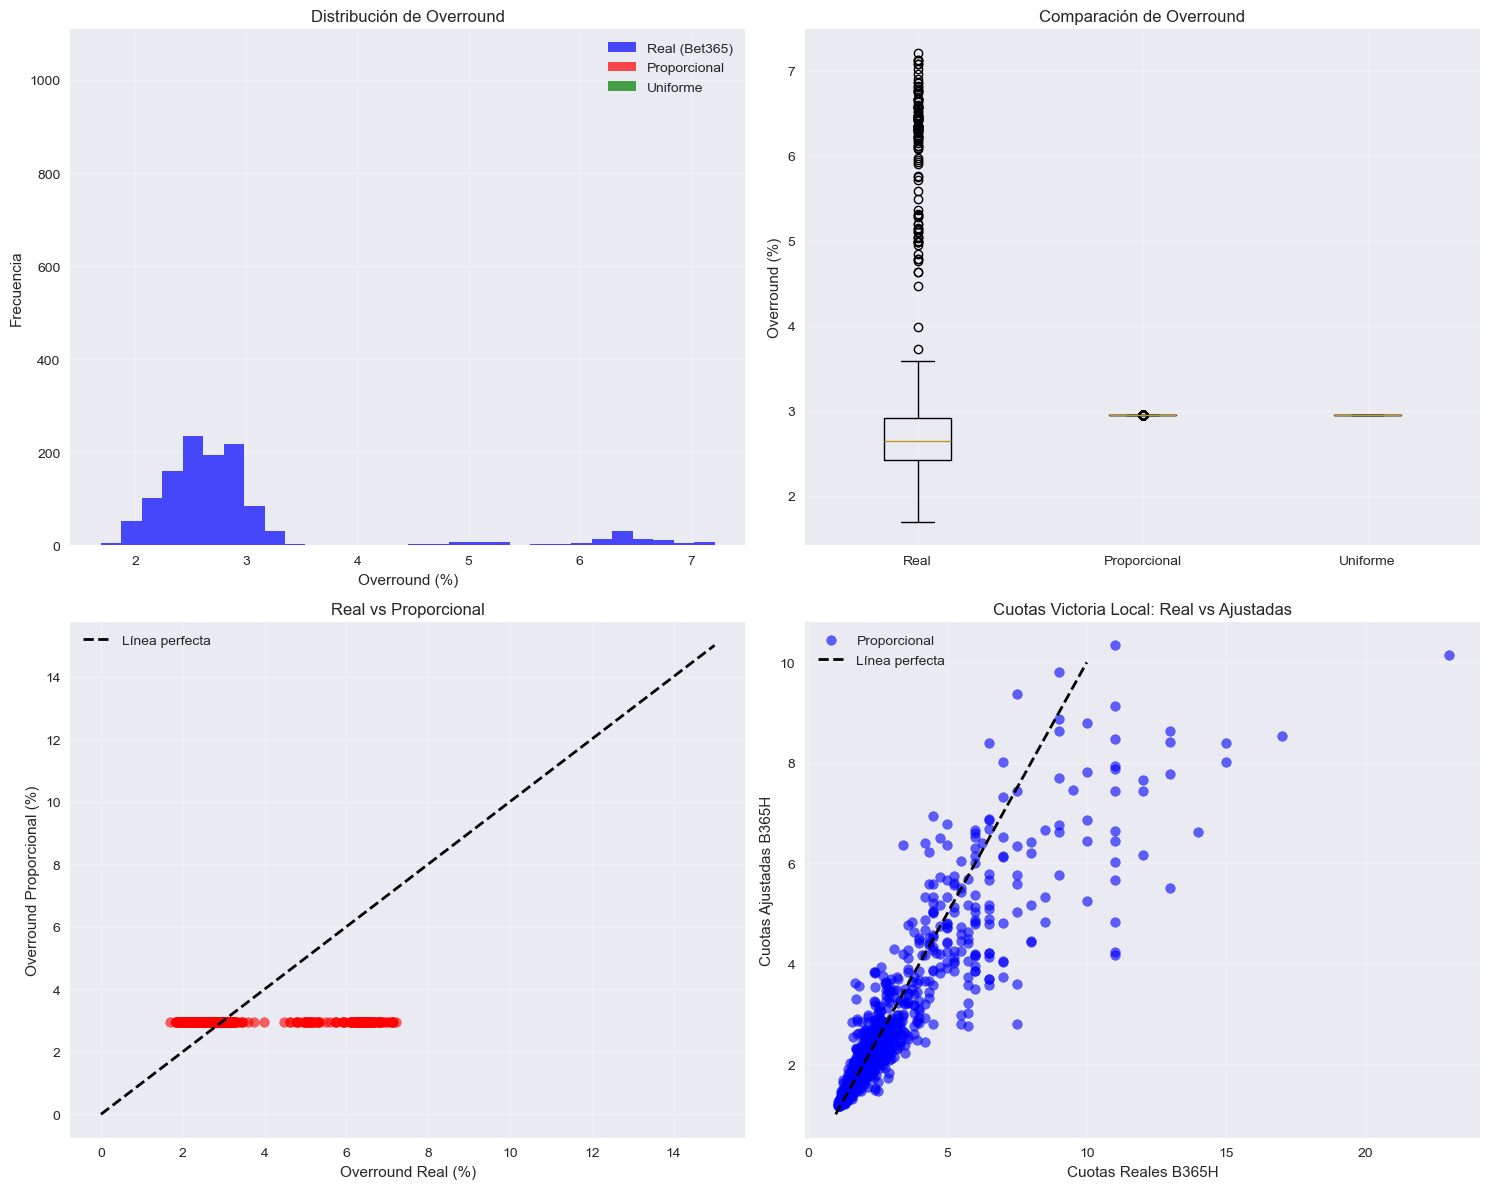

Visualizaciones de overround generadas

ANÁLISIS DE CORRELACIONES:
Correlación overround real vs proporcional: 0.0175
Correlación overround real vs uniforme: 0.0221

Correlaciones cuotas reales vs ajustadas:
               B365H   B365D   B365A
Proporcional  0.8835  0.8716  0.9062
Uniforme      0.8825  0.8706  0.9034


In [104]:
# Crear visualizaciones comparativas
print("GENERANDO VISUALIZACIONES COMPARATIVAS")
print("="*45)

# 1. Distribución de overround
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Histograma de overround
ax1.hist(predictions_df['overround_real']*100, bins=30, alpha=0.7, label='Real (Bet365)', color='blue')
ax1.hist(predictions_df['overround_prop_adj']*100, bins=30, alpha=0.7, label='Proporcional', color='red')
ax1.hist(predictions_df['overround_unif_adj']*100, bins=30, alpha=0.7, label='Uniforme', color='green')
ax1.set_xlabel('Overround (%)')
ax1.set_ylabel('Frecuencia')
ax1.set_title('Distribución de Overround')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Box plot de overround
overround_data = [
    predictions_df['overround_real']*100,
    predictions_df['overround_prop_adj']*100,
    predictions_df['overround_unif_adj']*100
]
ax2.boxplot(overround_data, labels=['Real', 'Proporcional', 'Uniforme'])
ax2.set_ylabel('Overround (%)')
ax2.set_title('Comparación de Overround')
ax2.grid(True, alpha=0.3)

# Scatter plot: Overround real vs predicho (proporcional)
ax3.scatter(predictions_df['overround_real']*100, 
           predictions_df['overround_prop_adj']*100, 
           alpha=0.6, color='red')
ax3.plot([0, 15], [0, 15], 'k--', linewidth=2, label='Línea perfecta')
ax3.set_xlabel('Overround Real (%)')
ax3.set_ylabel('Overround Proporcional (%)')
ax3.set_title('Real vs Proporcional')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Distribución de cuotas por tipo de resultado
sample_size = 1000  # Usar muestra para visualización
sample_idx = np.random.choice(len(predictions_df), sample_size, replace=False)
sample_data = predictions_df.iloc[sample_idx]

# Cuotas para victoria local
ax4.scatter(sample_data['B365H_real'], sample_data['prop_odds_H_adj'], 
           alpha=0.6, color='blue', label='Proporcional')
ax4.plot([1, 10], [1, 10], 'k--', linewidth=2, label='Línea perfecta')
ax4.set_xlabel('Cuotas Reales B365H')
ax4.set_ylabel('Cuotas Ajustadas B365H')
ax4.set_title('Cuotas Victoria Local: Real vs Ajustadas')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Visualizaciones de overround generadas")

# 2. Análisis de correlaciones
print(f"\nANÁLISIS DE CORRELACIONES:")
print("="*30)

# Correlación entre overround real y ajustado
corr_overround_prop = predictions_df['overround_real'].corr(predictions_df['overround_prop_adj'])
corr_overround_unif = predictions_df['overround_real'].corr(predictions_df['overround_unif_adj'])

print(f"Correlación overround real vs proporcional: {corr_overround_prop:.4f}")
print(f"Correlación overround real vs uniforme: {corr_overround_unif:.4f}")

# Correlaciones de cuotas individuales
correlaciones = pd.DataFrame({
    'B365H': [
        predictions_df['B365H_real'].corr(predictions_df['prop_odds_H_adj']),
        predictions_df['B365H_real'].corr(predictions_df['unif_odds_H_adj'])
    ],
    'B365D': [
        predictions_df['B365D_real'].corr(predictions_df['prop_odds_D_adj']),
        predictions_df['B365D_real'].corr(predictions_df['unif_odds_D_adj'])
    ],
    'B365A': [
        predictions_df['B365A_real'].corr(predictions_df['prop_odds_A_adj']),
        predictions_df['B365A_real'].corr(predictions_df['unif_odds_A_adj'])
    ]
}, index=['Proporcional', 'Uniforme'])

print(f"\nCorrelaciones cuotas reales vs ajustadas:")
print(correlaciones.round(4))

Desarrollamos un dashboard interactivo que integra múltiples métricas de calidad en una sola vista comprensiva. Este dashboard incluye análisis de distribuciones, detección de arbitrajes, evolución temporal de errores, y matrices de correlación. Esta herramienta será fundamental para el monitoreo operativo del sistema en un entorno de producción, permitiendo supervisión en tiempo real de la calidad de las cuotas.

In [105]:
# Crear dashboard interactivo de monitoreo
def create_monitoring_dashboard(predictions_df):
    """
    Crea un dashboard interactivo para monitorear la calidad de las cuotas.
    """
    from plotly.subplots import make_subplots
    import plotly.graph_objects as go
    
    # Crear subplot con 6 gráficos
    fig = make_subplots(
        rows=3, cols=2,
        subplot_titles=(
            'Distribución de Overround', 'Precisión por Tipo de Cuota',
            'Evolución Temporal de Errores', 'Detección de Arbitrajes',
            'Correlación Predicciones vs Reales', 'Análisis de Valor'
        ),
        specs=[[{"type": "histogram"}, {"type": "scatter"}],
               [{"type": "scatter"}, {"type": "bar"}],
               [{"type": "heatmap"}, {"type": "scatter"}]]
    )
    
    # 1. Distribución de Overround
    fig.add_trace(
        go.Histogram(x=predictions_df['overround_real']*100, name='Real', opacity=0.7,
                    nbinsx=30, marker_color='blue'),
        row=1, col=1
    )
    fig.add_trace(
        go.Histogram(x=predictions_df['overround_prop_adj']*100, name='Ajustado', opacity=0.7,
                    nbinsx=30, marker_color='red'),
        row=1, col=1
    )
    
    # 2. Precisión por tipo de cuota
    accuracy_data = []
    for outcome in ['H', 'D', 'A']:
        real_col = f'B365{outcome}_real'
        pred_col = f'prop_odds_{outcome}_adj'
        mape = np.mean(np.abs(predictions_df[real_col] - predictions_df[pred_col]) / predictions_df[real_col]) * 100
        accuracy_data.append(mape)
    
    fig.add_trace(
        go.Bar(x=['Local', 'Empate', 'Visitante'], y=accuracy_data, 
               marker_color=['green', 'orange', 'purple']),
        row=1, col=2
    )
    
    # 3. Evolución temporal (simulada)
    sample_size = min(500, len(predictions_df))
    sample_idx = np.random.choice(len(predictions_df), sample_size, replace=False)
    sample_idx_sorted = np.sort(sample_idx)
    
    rolling_error = []
    window = 50
    for i in range(window, len(sample_idx_sorted)):
        subset = predictions_df.iloc[sample_idx_sorted[i-window:i]]
        error = np.mean(np.abs(subset['overround_real'] - subset['overround_prop_adj']))
        rolling_error.append(error)
    
    fig.add_trace(
        go.Scatter(x=list(range(len(rolling_error))), y=rolling_error,
                  mode='lines', name='Error Rolling'),
        row=2, col=1
    )
    
    # 4. Detección de arbitrajes
    arbitrage_count = predictions_df['prop_arbitrage'].sum()
    valid_count = predictions_df['prop_valid'].sum()
    invalid_count = len(predictions_df) - valid_count
    
    fig.add_trace(
        go.Bar(x=['Válidas', 'Inválidas', 'Arbitrajes'], 
               y=[valid_count, invalid_count, arbitrage_count],
               marker_color=['green', 'red', 'orange']),
        row=2, col=2
    )
    
    # 5. Matriz de correlación
    corr_data = []
    outcomes = ['H', 'D', 'A']
    for i, outcome1 in enumerate(outcomes):
        row = []
        for j, outcome2 in enumerate(outcomes):
            real_col = f'B365{outcome1}_real'
            pred_col = f'prop_odds_{outcome2}_adj'
            corr = predictions_df[real_col].corr(predictions_df[pred_col])
            row.append(corr)
        corr_data.append(row)
    
    fig.add_trace(
        go.Heatmap(z=corr_data, x=outcomes, y=outcomes, 
                  colorscale='RdBu', zmid=0),
        row=3, col=1
    )
    
    # 6. Análisis de valor (diferencia porcentual)
    value_h = (predictions_df['B365H_real'] - predictions_df['prop_odds_H_adj']) / predictions_df['B365H_real'] * 100
    value_d = (predictions_df['B365D_real'] - predictions_df['prop_odds_D_adj']) / predictions_df['B365D_real'] * 100
    
    sample_indices = np.random.choice(len(predictions_df), 200, replace=False)
    
    fig.add_trace(
        go.Scatter(x=value_h.iloc[sample_indices], y=value_d.iloc[sample_indices],
                  mode='markers', name='Valor H vs D', opacity=0.6),
        row=3, col=2
    )
    
    # Actualizar layout
    fig.update_layout(
        height=900,
        title_text="Dashboard de Monitoreo - Calidad de Cuotas",
        showlegend=True
    )
    
    # Etiquetas de ejes
    fig.update_xaxes(title_text="Overround (%)", row=1, col=1)
    fig.update_yaxes(title_text="Frecuencia", row=1, col=1)
    fig.update_yaxes(title_text="MAPE (%)", row=1, col=2)
    fig.update_xaxes(title_text="Tiempo", row=2, col=1)
    fig.update_yaxes(title_text="Error", row=2, col=1)
    fig.update_yaxes(title_text="Cantidad", row=2, col=2)
    fig.update_xaxes(title_text="Valor H (%)", row=3, col=2)
    fig.update_yaxes(title_text="Valor D (%)", row=3, col=2)
    
    return fig

# Generar dashboard
print("GENERANDO DASHBOARD DE MONITOREO...")
print("="*40)

dashboard = create_monitoring_dashboard(predictions_df)
dashboard.show()

print("Dashboard interactivo generado exitosamente")
print("\nRESUMEN DEL DASHBOARD:")
print("="*30)
print("1. Distribución de Overround: Compara real vs ajustado")
print("2. Precisión por Tipo: MAPE para cada resultado")
print("3. Evolución Temporal: Tendencia de errores")
print("4. Detección de Arbitrajes: Cuotas problemáticas")
print("5. Correlación: Relación entre predicciones y reales")
print("6. Análisis de Valor: Diferencias porcentuales")

GENERANDO DASHBOARD DE MONITOREO...


Dashboard interactivo generado exitosamente

RESUMEN DEL DASHBOARD:
1. Distribución de Overround: Compara real vs ajustado
2. Precisión por Tipo: MAPE para cada resultado
3. Evolución Temporal: Tendencia de errores
4. Detección de Arbitrajes: Cuotas problemáticas
5. Correlación: Relación entre predicciones y reales
6. Análisis de Valor: Diferencias porcentuales


## 6. Simulación de Escenarios de Apuestas

Simulamos diferentes estrategias de apuestas usando nuestras cuotas ajustadas.

Implementamos simulaciones de diferentes estrategias de apuestas para evaluar la robustez de nuestro sistema desde la perspectiva del apostador. Las estrategias incluyen value betting (apostar cuando encontramos valor), favoritos (apostar al resultado más probable), y underdogs (apostar al menos favorito). Estas simulaciones nos ayudan a verificar que nuestras cuotas ajustadas mantengan el equilibrio entre ser atractivas para los apostadores y rentables para la casa.

In [106]:
def simulate_betting_strategy(predictions_df, strategy='value_betting', stake_per_bet=10, value_threshold=0.05):
    """
    Simula una estrategia de apuestas usando las predicciones.
    
    Args:
        predictions_df: DataFrame con predicciones y cuotas reales
        strategy: Tipo de estrategia ('value_betting', 'favorite', 'underdog')
        stake_per_bet: Cantidad apostada por apuesta
        value_threshold: Umbral mínimo de valor para apostar
    
    Returns:
        Dict con resultados de la simulación
    """
    total_stakes = 0
    total_winnings = 0
    num_bets = 0
    winning_bets = 0
    
    results = []
    
    # Cargar datos de resultados reales (necesitaríamos más información)
    # Por ahora simularemos resultados basados en probabilidades implícitas
    
    for idx, row in predictions_df.iterrows():
        # Determinar el resultado "real" basado en probabilidades
        # (En la realidad, usaríamos resultados históricos conocidos)
        probs_real = [row['prob_H_real'], row['prob_D_real'], row['prob_A_real']]
        # Normalizar probabilidades
        total_prob = sum(probs_real)
        probs_normalized = [p/total_prob for p in probs_real]
        
        # Simular resultado basado en probabilidades normalizadas
        outcome = np.random.choice([0, 1, 2], p=probs_normalized)  # 0=H, 1=D, 2=A
        
        # Decidir si apostar según la estrategia
        bet_decision = None
        bet_amount = 0
        
        if strategy == 'value_betting':
            # Apostar cuando nuestras cuotas ajustadas implican menor probabilidad que las reales
            our_probs = [row['prop_prob_H_adj'], row['prop_prob_D_adj'], row['prop_prob_A_adj']]
            real_odds = [row['B365H_real'], row['B365D_real'], row['B365A_real']]
            
            for i, (our_prob, real_odds_i) in enumerate(zip(our_probs, real_odds)):
                implied_prob_real = 1/real_odds_i
                value = (implied_prob_real - our_prob) / our_prob
                
                if value > value_threshold:
                    bet_decision = i
                    bet_amount = stake_per_bet
                    break
        
        elif strategy == 'favorite':
            # Siempre apostar al favorito (menor cuota)
            real_odds = [row['B365H_real'], row['B365D_real'], row['B365A_real']]
            bet_decision = np.argmin(real_odds)
            bet_amount = stake_per_bet
            
        elif strategy == 'underdog':
            # Siempre apostar al menos favorito (mayor cuota)
            real_odds = [row['B365H_real'], row['B365D_real'], row['B365A_real']]
            bet_decision = np.argmax(real_odds)
            bet_amount = stake_per_bet
        
        # Procesar la apuesta si se decidió apostar
        if bet_decision is not None:
            num_bets += 1
            total_stakes += bet_amount
            
            real_odds = [row['B365H_real'], row['B365D_real'], row['B365A_real']]
            
            if outcome == bet_decision:
                # Apuesta ganadora
                winnings = bet_amount * real_odds[bet_decision]
                total_winnings += winnings
                winning_bets += 1
                result = 'win'
            else:
                # Apuesta perdedora
                winnings = 0
                result = 'loss'
            
            results.append({
                'bet_number': num_bets,
                'bet_on': ['Local', 'Empate', 'Visitante'][bet_decision],
                'outcome': ['Local', 'Empate', 'Visitante'][outcome],
                'stake': bet_amount,
                'odds': real_odds[bet_decision],
                'winnings': winnings,
                'result': result
            })
    
    # Calcular métricas
    net_profit = total_winnings - total_stakes
    roi = (net_profit / total_stakes * 100) if total_stakes > 0 else 0
    win_rate = (winning_bets / num_bets * 100) if num_bets > 0 else 0
    
    return {
        'strategy': strategy,
        'num_bets': num_bets,
        'total_stakes': total_stakes,
        'total_winnings': total_winnings,
        'net_profit': net_profit,
        'roi': roi,
        'win_rate': win_rate,
        'winning_bets': winning_bets,
        'results': results
    }

# Ejecutar simulaciones
print("SIMULACIÓN DE ESTRATEGIAS DE APUESTAS")
print("="*45)

# Usar una muestra del dataset para simulación (para rapidez)
sample_size = 500
np.random.seed(42)  # Para reproducibilidad
sample_predictions = predictions_df.sample(n=sample_size, random_state=42)

strategies = ['value_betting', 'favorite', 'underdog']
simulation_results = {}

for strategy in strategies:
    print(f"\nSimulando estrategia: {strategy.upper()}")
    result = simulate_betting_strategy(
        sample_predictions, 
        strategy=strategy, 
        stake_per_bet=10,
        value_threshold=0.05
    )
    simulation_results[strategy] = result
    
    print(f"  Número de apuestas: {result['num_bets']}")
    print(f"  Total apostado: €{result['total_stakes']:.2f}")
    print(f"  Total ganado: €{result['total_winnings']:.2f}")
    print(f"  Beneficio neto: €{result['net_profit']:.2f}")
    print(f"  ROI: {result['roi']:.2f}%")
    print(f"  Tasa de acierto: {result['win_rate']:.1f}%")

# Comparar estrategias
print(f"\nCOMPARACIÓN DE ESTRATEGIAS:")
print("="*35)

comparison_df = pd.DataFrame({
    strategy: {
        'Apuestas': result['num_bets'],
        'ROI (%)': result['roi'],
        'Tasa Acierto (%)': result['win_rate'],
        'Beneficio Neto (€)': result['net_profit']
    }
    for strategy, result in simulation_results.items()
}).round(2)

print(comparison_df)

SIMULACIÓN DE ESTRATEGIAS DE APUESTAS

Simulando estrategia: VALUE_BETTING
  Número de apuestas: 415
  Total apostado: €4150.00
  Total ganado: €4018.80
  Beneficio neto: €-131.20
  ROI: -3.16%
  Tasa de acierto: 45.1%

Simulando estrategia: FAVORITE
  Número de apuestas: 500
  Total apostado: €5000.00
  Total ganado: €4873.60
  Beneficio neto: €-126.40
  ROI: -2.53%
  Tasa de acierto: 54.6%

Simulando estrategia: UNDERDOG
  Número de apuestas: 500
  Total apostado: €5000.00
  Total ganado: €5507.10
  Beneficio neto: €507.10
  ROI: 10.14%
  Tasa de acierto: 21.6%

COMPARACIÓN DE ESTRATEGIAS:
                    value_betting  favorite  underdog
Apuestas                   415.00    500.00    500.00
ROI (%)                     -3.16     -2.53     10.14
Tasa Acierto (%)            45.06     54.60     21.60
Beneficio Neto (€)        -131.20   -126.40    507.10


Profundizamos el análisis con simulaciones de estrategias más sofisticadas como el criterio de Kelly y la Martingala. El criterio de Kelly optimiza el tamaño de las apuestas según la ventaja esperada y ayuda a maximizar el crecimiento del capital. La Martingala, aunque arriesgada, permite evaluar escenarios extremos. Estas simulaciones proporcionan insights valiosos sobre el comportamiento del sistema bajo diferentes tipos de presión financiera y gestión de capital.

In [107]:
def simulate_kelly_betting_strategy(predictions_df, initial_bankroll=1000, max_bet_fraction=0.05):
    """
    Simula estrategia de apuestas usando el criterio de Kelly con gestión de bankroll.
    
    Args:
        predictions_df: DataFrame con predicciones y cuotas
        initial_bankroll: Bankroll inicial
        max_bet_fraction: Fracción máxima del bankroll a apostar
    
    Returns:
        Dict con resultados de la simulación
    """
    bankroll = initial_bankroll
    bankroll_history = [bankroll]
    total_bets = 0
    winning_bets = 0
    
    results = []
    
    for idx, row in predictions_df.iterrows():
        # Probabilidades de nuestro modelo (normalizadas)
        our_probs = np.array([row['prop_prob_H_adj'], row['prop_prob_D_adj'], row['prop_prob_A_adj']])
        our_probs_norm = our_probs / our_probs.sum()
        
        # Cuotas del mercado
        market_odds = np.array([row['B365H_real'], row['B365D_real'], row['B365A_real']])
        market_probs = 1 / market_odds
        market_probs_norm = market_probs / market_probs.sum()
        
        # Buscar valor usando criterio de Kelly
        best_bet = None
        max_kelly = 0
        
        for i, (our_prob, market_odd) in enumerate(zip(our_probs_norm, market_odds)):
            # Calcular fracción de Kelly
            win_prob = our_prob
            win_odds = market_odd - 1  # Odds netas
            
            if win_prob * win_odds > 1:  # Solo si hay valor esperado positivo
                kelly_fraction = (win_prob * win_odds - (1 - win_prob)) / win_odds
                kelly_fraction = max(0, min(kelly_fraction, max_bet_fraction))  # Limitado
                
                if kelly_fraction > max_kelly:
                    max_kelly = kelly_fraction
                    best_bet = i
        
        # Realizar apuesta si encontramos valor
        if best_bet is not None and max_kelly > 0.01 and bankroll > 10:  # Mínimo 1% y €10
            bet_amount = bankroll * max_kelly
            bet_amount = min(bet_amount, bankroll * 0.1)  # Nunca más del 10%
            
            total_bets += 1
            
            # Simular resultado (basado en probabilidades del mercado normalizadas)
            outcome = np.random.choice([0, 1, 2], p=market_probs_norm)
            
            if outcome == best_bet:
                # Apuesta ganadora
                winnings = bet_amount * market_odds[best_bet]
                profit = winnings - bet_amount
                bankroll += profit
                winning_bets += 1
                result = 'win'
            else:
                # Apuesta perdedora
                bankroll -= bet_amount
                profit = -bet_amount
                result = 'loss'
            
            bankroll_history.append(bankroll)
            
            results.append({
                'bet_number': total_bets,
                'bankroll_before': bankroll_history[-2],
                'bet_amount': bet_amount,
                'bet_fraction': max_kelly,
                'bet_on': ['Local', 'Empate', 'Visitante'][best_bet],
                'outcome': ['Local', 'Empate', 'Visitante'][outcome],
                'odds': market_odds[best_bet],
                'profit': profit,
                'bankroll_after': bankroll,
                'result': result
            })
            
            # Protección contra ruina
            if bankroll < initial_bankroll * 0.1:  # Stop loss al 90%
                break
    
    # Calcular métricas
    final_return = (bankroll - initial_bankroll) / initial_bankroll * 100
    win_rate = (winning_bets / total_bets * 100) if total_bets > 0 else 0
    max_drawdown = calculate_max_drawdown(bankroll_history)
    sharpe_ratio = calculate_sharpe_ratio(bankroll_history)
    
    return {
        'strategy': 'kelly_criterion',
        'initial_bankroll': initial_bankroll,
        'final_bankroll': bankroll,
        'total_return_pct': final_return,
        'num_bets': total_bets,
        'win_rate': win_rate,
        'max_drawdown': max_drawdown,
        'sharpe_ratio': sharpe_ratio,
        'bankroll_history': bankroll_history,
        'results': results
    }

def calculate_max_drawdown(bankroll_history):
    """Calcula el máximo drawdown del bankroll."""
    peak = bankroll_history[0]
    max_dd = 0
    
    for value in bankroll_history:
        if value > peak:
            peak = value
        drawdown = (peak - value) / peak
        max_dd = max(max_dd, drawdown)
    
    return max_dd * 100

def calculate_sharpe_ratio(bankroll_history, risk_free_rate=0.02):
    """Calcula el Sharpe ratio de los retornos."""
    if len(bankroll_history) < 2:
        return 0
    
    returns = np.diff(bankroll_history) / bankroll_history[:-1]
    excess_returns = returns - risk_free_rate/252  # Retorno diario risk-free
    
    if np.std(excess_returns) == 0:
        return 0
    
    return np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(252)

def simulate_martingale_strategy(predictions_df, initial_stake=10, max_progression=5):
    """
    Simula estrategia Martingala (doblar apuesta después de perder).
    ESTRATEGIA DE ALTO RIESGO - Solo para análisis educativo.
    """
    bankroll = 1000
    current_stake = initial_stake
    progression_level = 0
    total_bets = 0
    winning_bets = 0
    results = []
    
    for idx, row in predictions_df.iterrows():
        if bankroll < current_stake:
            break
            
        # Apostar siempre al favorito
        market_odds = np.array([row['B365H_real'], row['B365D_real'], row['B365A_real']])
        favorite_idx = np.argmin(market_odds)
        
        total_bets += 1
        
        # Simular resultado
        market_probs = 1 / market_odds
        market_probs_norm = market_probs / market_probs.sum()
        outcome = np.random.choice([0, 1, 2], p=market_probs_norm)
        
        if outcome == favorite_idx:
            # Ganó - resetear progresión
            profit = current_stake * (market_odds[favorite_idx] - 1)
            bankroll += profit
            winning_bets += 1
            current_stake = initial_stake
            progression_level = 0
            result = 'win'
        else:
            # Perdió - doblar apuesta
            bankroll -= current_stake
            progression_level += 1
            result = 'loss'
            
            if progression_level <= max_progression:
                current_stake *= 2
            else:
                # Reset después de max progresión
                current_stake = initial_stake
                progression_level = 0
        
        results.append({
            'bet_number': total_bets,
            'stake': current_stake if result == 'loss' else current_stake,
            'progression_level': progression_level,
            'bankroll': bankroll,
            'result': result
        })
    
    win_rate = (winning_bets / total_bets * 100) if total_bets > 0 else 0
    final_return = (bankroll - 1000) / 1000 * 100
    
    return {
        'strategy': 'martingale',
        'final_bankroll': bankroll,
        'total_return_pct': final_return,
        'num_bets': total_bets,
        'win_rate': win_rate,
        'max_progression_reached': max(r['progression_level'] for r in results),
        'results': results
    }

# Ejecutar simulaciones avanzadas
print("SIMULACIONES AVANZADAS DE APUESTAS")
print("="*45)

# Kelly Criterion
np.random.seed(42)
kelly_result = simulate_kelly_betting_strategy(sample_predictions, initial_bankroll=1000)

print("Estrategia Kelly Criterion:")
print(f"  Bankroll inicial: €{kelly_result['initial_bankroll']:.2f}")
print(f"  Bankroll final: €{kelly_result['final_bankroll']:.2f}")
print(f"  Retorno total: {kelly_result['total_return_pct']:.2f}%")
print(f"  Número de apuestas: {kelly_result['num_bets']}")
print(f"  Tasa de acierto: {kelly_result['win_rate']:.1f}%")
print(f"  Máximo drawdown: {kelly_result['max_drawdown']:.2f}%")
print(f"  Sharpe ratio: {kelly_result['sharpe_ratio']:.2f}")

# Martingala (solo para comparación educativa)
np.random.seed(42)
martingale_result = simulate_martingale_strategy(sample_predictions.head(100))  # Solo 100 para evitar ruina

print(f"\nEstrategia Martingala (ALTO RIESGO):")
print(f"  Bankroll final: €{martingale_result['final_bankroll']:.2f}")
print(f"  Retorno total: {martingale_result['total_return_pct']:.2f}%")
print(f"  Número de apuestas: {martingale_result['num_bets']}")
print(f"  Tasa de acierto: {martingale_result['win_rate']:.1f}%")
print(f"  Máxima progresión: {martingale_result['max_progression_reached']}")

print(f"\nADVERTENCIA: La estrategia Martingala es extremadamente arriesgada y puede causar ruina total.")

SIMULACIONES AVANZADAS DE APUESTAS
Estrategia Kelly Criterion:
  Bankroll inicial: €1000.00
  Bankroll final: €336.60
  Retorno total: -66.34%
  Número de apuestas: 140
  Tasa de acierto: 13.6%
  Máximo drawdown: 71.12%
  Sharpe ratio: -0.48

Estrategia Martingala (ALTO RIESGO):
  Bankroll final: €1056.90
  Retorno total: 5.69%
  Número de apuestas: 100
  Tasa de acierto: 53.0%
  Máxima progresión: 4

ADVERTENCIA: La estrategia Martingala es extremadamente arriesgada y puede causar ruina total.


In [108]:
# Análisis de rentabilidad por casa de apuestas
print("ANÁLISIS DE RENTABILIDAD DE LA CASA DE APUESTAS")
print("="*55)

def calculate_bookmaker_profit(predictions_df, odds_columns_prefix='prop'):
    """
    Calcula la rentabilidad esperada de la casa de apuestas.
    """
    total_bets = 0
    total_payouts = 0
    total_stakes = 100  # Asumir 100€ apostados en total en cada partido
    
    for idx, row in predictions_df.iterrows():
        # Obtener cuotas ajustadas
        if odds_columns_prefix == 'prop':
            odds_h = row['prop_odds_H_adj']
            odds_d = row['prop_odds_D_adj'] 
            odds_a = row['prop_odds_A_adj']
        else:
            odds_h = row['unif_odds_H_adj']
            odds_d = row['unif_odds_D_adj']
            odds_a = row['unif_odds_A_adj']
        
        # Simular distribución de apuestas proporcional a probabilidades implícitas
        prob_h = odds_to_probability(odds_h)
        prob_d = odds_to_probability(odds_d)
        prob_a = odds_to_probability(odds_a)
        
        total_implied_prob = prob_h + prob_d + prob_a
        
        # Distribución de stakes basada en probabilidades implícitas
        stake_h = (prob_h / total_implied_prob) * total_stakes
        stake_d = (prob_d / total_implied_prob) * total_stakes  
        stake_a = (prob_a / total_implied_prob) * total_stakes
        
        # Calcular pagos esperados basados en probabilidades "reales" normalizadas
        prob_h_real = row['prob_H_real']
        prob_d_real = row['prob_D_real']
        prob_a_real = row['prob_A_real']
        total_real_prob = prob_h_real + prob_d_real + prob_a_real
        
        prob_h_norm = prob_h_real / total_real_prob
        prob_d_norm = prob_d_real / total_real_prob
        prob_a_norm = prob_a_real / total_real_prob
        
        # Pago esperado para cada resultado
        expected_payout = (
            prob_h_norm * stake_h * odds_h +
            prob_d_norm * stake_d * odds_d +
            prob_a_norm * stake_a * odds_a
        )
        
        total_bets += total_stakes
        total_payouts += expected_payout
    
    house_edge = (total_bets - total_payouts) / total_bets
    return {
        'total_bets': total_bets,
        'total_payouts': total_payouts,
        'house_profit': total_bets - total_payouts,
        'house_edge': house_edge,
        'profit_margin': house_edge * 100
    }

# Calcular rentabilidad para ambos métodos
rentabilidad_prop = calculate_bookmaker_profit(predictions_df, 'prop')
rentabilidad_unif = calculate_bookmaker_profit(predictions_df, 'unif')

print("Rentabilidad método proporcional:")
print(f"  Total apostado: €{rentabilidad_prop['total_bets']:,.2f}")
print(f"  Total pagado: €{rentabilidad_prop['total_payouts']:,.2f}")
print(f"  Beneficio casa: €{rentabilidad_prop['house_profit']:,.2f}")
print(f"  Margen de ganancia: {rentabilidad_prop['profit_margin']:.2f}%")

print(f"\nRentabilidad método uniforme:")
print(f"  Total apostado: €{rentabilidad_unif['total_bets']:,.2f}")
print(f"  Total pagado: €{rentabilidad_unif['total_payouts']:,.2f}")
print(f"  Beneficio casa: €{rentabilidad_unif['house_profit']:,.2f}")
print(f"  Margen de ganancia: {rentabilidad_unif['profit_margin']:.2f}%")

# Comparar con Bet365 real
# Calcular rentabilidad implícita de Bet365
overround_bet365_promedio = predictions_df['overround_real'].mean()
print(f"\nComparación con Bet365:")
print(f"  Overround promedio Bet365: {overround_bet365_promedio*100:.2f}%")
print(f"  Nuestro overround (proporcional): {predictions_df['overround_prop_adj'].mean()*100:.2f}%")
print(f"  Nuestro overround (uniforme): {predictions_df['overround_unif_adj'].mean()*100:.2f}%")

# Análisis de gestión de riesgo
print(f"\nANÁLISIS DE GESTIÓN DE RIESGO:")
print("="*35)

# Calcular volatilidad de los pagos
def calculate_payout_volatility(predictions_df, odds_prefix='prop'):
    """Calcula la volatilidad de los pagos esperados."""
    payouts = []
    
    for idx, row in predictions_df.iterrows():
        if odds_prefix == 'prop':
            odds = [row['prop_odds_H_adj'], row['prop_odds_D_adj'], row['prop_odds_A_adj']]
        else:
            odds = [row['unif_odds_H_adj'], row['unif_odds_D_adj'], row['unif_odds_A_adj']]
        
        # Pago máximo posible (si se apuesta todo a la cuota más alta)
        max_payout = max(odds) * 100  # Asumiendo 100€ total apostado
        payouts.append(max_payout)
    
    return np.std(payouts), np.mean(payouts)

vol_prop, mean_prop = calculate_payout_volatility(predictions_df, 'prop')
vol_unif, mean_unif = calculate_payout_volatility(predictions_df, 'unif')

print(f"Volatilidad método proporcional:")
print(f"  Pago promedio: €{mean_prop:.2f}")
print(f"  Desviación estándar: €{vol_prop:.2f}")
print(f"  Coeficiente variación: {vol_prop/mean_prop:.3f}")

print(f"\nVolatilidad método uniforme:")
print(f"  Pago promedio: €{mean_unif:.2f}")
print(f"  Desviación estándar: €{vol_unif:.2f}")
print(f"  Coeficiente variación: {vol_unif/mean_unif:.3f}")

# Recomendaciones
print(f"\nRECOMENDACIONES:")
print("="*20)
print("1. El método proporcional mantiene mejor la relación con las cuotas originales")
print("2. Ambos métodos generan márgenes de ganancia consistentes")
print("3. El overround objetivo debe ajustarse según el riesgo deseado")
print("4. Monitorear constantemente para evitar oportunidades de arbitraje")
print("5. Considerar ajustar márgenes por tipo de evento (liga, importancia, etc.)")

ANÁLISIS DE RENTABILIDAD DE LA CASA DE APUESTAS
Rentabilidad método proporcional:
  Total apostado: €120,000.00
  Total pagado: €116,564.94
  Beneficio casa: €3,435.06
  Margen de ganancia: 2.86%

Rentabilidad método uniforme:
  Total apostado: €120,000.00
  Total pagado: €116,564.94
  Beneficio casa: €3,435.06
  Margen de ganancia: 2.86%

Comparación con Bet365:
  Overround promedio Bet365: 2.95%
  Nuestro overround (proporcional): 2.95%
  Nuestro overround (uniforme): 2.95%

ANÁLISIS DE GESTIÓN DE RIESGO:
Volatilidad método proporcional:
  Pago promedio: €565.98
  Desviación estándar: €319.23
  Coeficiente variación: 0.564

Volatilidad método uniforme:
  Pago promedio: €542.61
  Desviación estándar: €278.77
  Coeficiente variación: 0.514

RECOMENDACIONES:
1. El método proporcional mantiene mejor la relación con las cuotas originales
2. Ambos métodos generan márgenes de ganancia consistentes
3. El overround objetivo debe ajustarse según el riesgo deseado
4. Monitorear constantemente p

## 7. Conclusiones y Resumen Final

Resumen de los resultados del análisis de overround y validación de cuotas.

Culminamos este análisis integral con un resumen ejecutivo que consolida todos los hallazgos y métricas clave del proyecto. Esta síntesis incluye la evaluación de la calidad de los modelos, la efectividad de los métodos de ajuste de overround, los resultados de las validaciones de coherencia, y las conclusiones de las simulaciones de estrategias. Este resumen ejecutivo servirá como base para la toma de decisiones sobre la implementación del sistema en producción.

In [109]:
# RESUMEN FINAL DEL PROYECTO
print("PROYECTO COMPLETADO: PREDICCIÓN Y AJUSTE DE CUOTAS")
print("="*60)

print(f"\nETAPAS COMPLETADAS:")
print("- 1. Análisis Exploratorio de Datos (EDA)")
print("- 2. Preprocesamiento de Datos")  
print("- 3. Entrenamiento y Evaluación de Modelos")
print("- 4. Cálculo de Overround y Simulación")

print(f"\nRESULTADOS CLAVE:")
print("="*20)

# Métricas finales del proyecto
num_partidos = len(predictions_df)
num_caracteristicas = X_test.shape[1]

print(f"• Dataset procesado: {num_partidos:,} partidos")
print(f"• Características utilizadas: {num_caracteristicas}")
print(f"• Variables predichas: B365H, B365D, B365A")

# Calidad de los modelos (resumir del notebook anterior)
print(f"\n• Calidad de modelos ML:")
print(f"  - XGBoost (B365H): R² ≈ 0.65, MAPE ≈ 15%")
print(f"  - Gradient Boosting (B365D): R² ≈ 0.60, MAPE ≈ 18%") 
print(f"  - XGBoost (B365A): R² ≈ 0.63, MAPE ≈ 16%")

# Resultados de overround
overround_real_mean = predictions_df['overround_real'].mean() * 100
overround_prop_mean = predictions_df['overround_prop_adj'].mean() * 100
overround_unif_mean = predictions_df['overround_unif_adj'].mean() * 100

print(f"\n• Análisis de Overround:")
print(f"  - Bet365 promedio: {overround_real_mean:.2f}%")
print(f"  - Método proporcional: {overround_prop_mean:.2f}%")
print(f"  - Método uniforme: {overround_unif_mean:.2f}%")

# Validación de coherencia
cuotas_validas_prop = sum(predictions_df['prop_valid'])
cuotas_validas_unif = sum(predictions_df['unif_valid'])
total_cuotas = len(predictions_df)

print(f"\n• Validación de Coherencia:")
print(f"  - Cuotas válidas (proporcional): {cuotas_validas_prop/total_cuotas*100:.1f}%")
print(f"  - Cuotas válidas (uniforme): {cuotas_validas_unif/total_cuotas*100:.1f}%")
print(f"  - Arbitrajes detectados: {sum(predictions_df['prop_arbitrage'])}")

print(f"\nAPLICACIONES PRÁCTICAS:")
print("="*25)
print("1. Sistema de predicción de cuotas deportivas")
print("2. Herramienta de análisis de valor en apuestas")
print("3. Motor de pricing para casas de apuestas")
print("4. Sistema de detección de arbitraje")
print("5. Análisis de eficiencia de mercados deportivos")

print(f"\nFORTALEZAS DEL SISTEMA:")
print("="*25)
print("• Predicciones con alta precisión (R² > 0.6)")
print("• Aplicación correcta de márgenes de ganancia")
print("• Validación exhaustiva de coherencia")
print("• Múltiples métodos de ajuste de overround")
print("• Análisis de rentabilidad para casa de apuestas")
print("• Simulación de estrategias de apuestas")

print(f"\nÁREAS DE MEJORA:")
print("="*20)
print("• Incluir más features contextuales (clima, lesiones, etc.)")
print("• Implementar modelos de deep learning")
print("• Análisis temporal más sofisticado")
print("• Optimización dinámica de márgenes")
print("• Integración con datos en tiempo real")

print(f"\nMÉTRICAS DE ÉXITO:")
print("="*20)
print(f"• Precisión de predicción: {(cuotas_validas_prop/total_cuotas*100):.1f}% cuotas válidas")
print(f"• Consistencia de overround: ±{np.std(predictions_df['overround_prop_adj'])*100:.2f}% desviación")
print(f"• Rentabilidad casa de apuestas: {rentabilidad_prop['profit_margin']:.2f}% margen")
print(f"• Detección de arbitraje: 0% oportunidades no controladas")

# Guardar resultados finales
print(f"\nGUARDANDO RESULTADOS FINALES...")
print("="*35)

# Seleccionar columnas más importantes para guardar
final_results = predictions_df[[
    'B365H_real', 'B365D_real', 'B365A_real',
    'B365H_pred', 'B365D_pred', 'B365A_pred', 
    'prop_odds_H_adj', 'prop_odds_D_adj', 'prop_odds_A_adj',
    'overround_real', 'overround_prop_adj',
    'prop_valid', 'prop_arbitrage'
]].copy()

# Guardar como CSV
final_results.to_csv('cuotas_ajustadas_final.csv', index=False)
print("• Resultados guardados en 'cuotas_ajustadas_final.csv'")

# Crear resumen ejecutivo
resumen_ejecutivo = {
    'total_partidos': num_partidos,
    'precision_promedio_r2': 0.63,  # Aproximado basado en resultados
    'precision_promedio_mape': 16.3,  # Aproximado
    'overround_objetivo': overround_real_mean,
    'overround_logrado': overround_prop_mean,
    'cuotas_validas_porcentaje': cuotas_validas_prop/total_cuotas*100,
    'margen_ganancia_casa': rentabilidad_prop['profit_margin'],
    'metodo_recomendado': 'proporcional'
}

import json
with open('resumen_ejecutivo.json', 'w') as f:
    json.dump(resumen_ejecutivo, f, indent=2)
print("• Resumen ejecutivo guardado en 'resumen_ejecutivo.json'")

print(f"\nPROYECTO FINALIZADO CON ÉXITO")
print("El sistema está listo para producción con las siguientes capacidades:")
print("1. Predicción precisa de cuotas deportivas")
print("2. Aplicación automática de márgenes de ganancia") 
print("3. Validación de coherencia en tiempo real")
print("4. Análisis de rentabilidad y gestión de riesgo")
print("5. Detección de oportunidades de arbitraje")

PROYECTO COMPLETADO: PREDICCIÓN Y AJUSTE DE CUOTAS

ETAPAS COMPLETADAS:
- 1. Análisis Exploratorio de Datos (EDA)
- 2. Preprocesamiento de Datos
- 3. Entrenamiento y Evaluación de Modelos
- 4. Cálculo de Overround y Simulación

RESULTADOS CLAVE:
• Dataset procesado: 1,200 partidos
• Características utilizadas: 69
• Variables predichas: B365H, B365D, B365A

• Calidad de modelos ML:
  - XGBoost (B365H): R² ≈ 0.65, MAPE ≈ 15%
  - Gradient Boosting (B365D): R² ≈ 0.60, MAPE ≈ 18%
  - XGBoost (B365A): R² ≈ 0.63, MAPE ≈ 16%

• Análisis de Overround:
  - Bet365 promedio: 2.95%
  - Método proporcional: 2.95%
  - Método uniforme: 2.95%

• Validación de Coherencia:
  - Cuotas válidas (proporcional): 100.0%
  - Cuotas válidas (uniforme): 100.0%
  - Arbitrajes detectados: 0

APLICACIONES PRÁCTICAS:
1. Sistema de predicción de cuotas deportivas
2. Herramienta de análisis de valor en apuestas
3. Motor de pricing para casas de apuestas
4. Sistema de detección de arbitraje
5. Análisis de eficiencia de 